# Data Visualization

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load all csv's

In [2]:
import pandas

viewFiles = {}
viewFiles["N0Mass="] = [0.6, 0.8, 1.0, 1.2, 1.2, 1.4, 1.6]
viewFiles["susyBench"]= [1, 2]
\
signal_file = {}

for N0mass in viewFiles["N0Mass="]:
    if N0mass not in signal_file:
        signal_file[N0mass] = {}
    for susyBench in viewFiles["susyBench"]:
        if susyBench not in signal_file[N0mass]:
            signal_file[N0mass][susyBench] = pandas.read_csv("decay3/SfMass=1000/N0Mass={0}/susyBench{1}/kinematic_variables.dat".format(N0mass, susyBench))

# background_file = pandas.read_csv("/content/drive/My Drive/Lip Summer Internships/HNL/Mumunu/kinematic_variables_HNL_decays.dat")


['Mother Total Momentum (GeV/c)', ' Mother Transverse Momentum (GeV/c)', ' Mother Fraction of Transverse Momentum', ' Opening Angle (rad)', ' Decay Angle (rad)', ' Impact Parameter (cm)', ' Daughter1 Total Momentum (GeV/c)', ' Daughter1 Transverse Momentum (GeV/c)', ' Daughter1 Fraction of Transverse Momentum', ' Daughter2 Total Momentum (GeV/c)', ' Daughter2 Transverse Momentum (GeV/c)', ' Daughter2 Fraction of Transverse Momentum', ' Decay Z (cm)', ' Decay X (cm)', ' Decay Y (cm)', ' Event type']


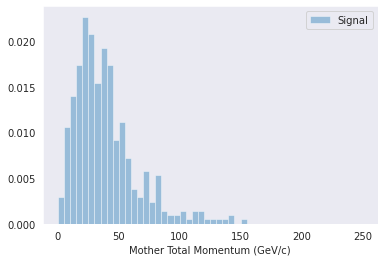

In [ ]:
import seaborn as sns
sns.set_style("dark")
import os
import json
import matplotlib.pyplot as plt

Signal = signal_file[0.6][1]
Background = background_file

FullData = Signal
ranges = dict()
r = [[0,250], [0,3], [0,0.2], [0,0.3], [3, 3.4], [0,1000], [0,80], [0,3], [0,0.2], [0,80], [0,3], [0,0.3],[-2600, 2600], [-300, 300], [-500, 500], [0,6], [-2, 6], [0,1]]
for i, col in enumerate(FullData.columns):
    try:
        ranges[col] = r[i]
    except:
        ranges[col] = [0,10]

print([col for col in FullData.columns])

for i, col in enumerate(FullData.columns):
    plt.figure(i)

    x = Signal[col]
    y = Background[col]

    ax = sns.distplot(x, hist_kws={"range": ranges[col]}, bins=50, norm_hist = True, kde=False, label = "Signal")#, fit=stats.gamma);
    # ax = sns.distplot(y, hist_kws={"range": ranges[col]}, bins=50, norm_hist = True, kde=False, label = "Background")#, fit=stats.gamma);
    # ax.set_xlim(ranges[col][0], ranges[col][1])
    plt.legend()

    #plt.savefig('/home/guilherme/Desktop/SHiP/DATA_VACUUM/DP/Images/' + str(i) +'.jpg')
    break


# Imports

In [24]:
from __future__ import division
from __future__ import print_function

%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
import numpy as np
import pandas
import timeit #more accurate than time

# import theano
import tensorflow

from sklearn.decomposition import PCA
# from sklearn.externals import joblib
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential, model_from_json, load_model, clone_model
# from keras.optimizers import SGD
# from keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam


from sklearn.utils import shuffle

from six.moves import cPickle #Faster than pickle


# Neural Nets functions

In [3]:
def getDistribuitionFitter(model, compileArgs):
    classModel = Sequential()
    depth = None
    width = None
    step = None
    fit_func = 'sigmoid' 
    layerSizes = []

    if model == "model1":   # for an approximately linear fit
        layerSizes = [20, 4, 5]
    elif model == "model0":
        layerSizes = [10, 5]        
    
    for i,width in enumerate(layerSizes):
        if i==0:
            classModel.add(Dense(width, input_shape=(1,), kernel_initializer='normal', activation=fit_func))
        else:
            classModel.add(Dense(width, kernel_initializer='normal', activation=fit_func))
    
    classModel.add(Dense(1, kernel_initializer='normal'))

    classModel.compile(**compileArgs)

    return classModel
  

In [ ]:
def getDistribuitionFitter_copy(model, compileArgs):
    classModel = Sequential()
    depth = None
    width = None
    step = None
    fit_func = 'sigmoid' 
    layerSizes = []

    if model == "model1":   
        layerSizes = [3,3,5]
        fit_func = 'tanh'
    elif model == "model0":
        # layerSizes = [10, 3, 4]        
        layerSizes = [20, 4, 5]

    # the neural network goes through some relu's at first, then goes to a final sigmoid or tanh layer for fitting
    for i,width in enumerate(layerSizes):
        if i==0:
            classModel.add(Dense(width, input_shape=(1,), kernel_initializer='normal', activation='sigmoid'))
        elif i==len(layerSizes)-1:
            classModel.add(Dense(width, kernel_initializer='normal', activation=fit_func))
        else:
            classModel.add(Dense(width, kernel_initializer='normal', activation='sigmoid'))

    
    classModel.add(Dense(1, kernel_initializer='normal'))

    classModel.compile(**compileArgs)

    return classModel

#Callbacks

In [4]:
class LossHistory(Callback):
    def __init__(self, trData):
        self.trainingData = trData
    def on_train_begin(self, logs={}):
        self.losses = {}
        self.losses['loss'] = []
        self.losses['val_loss'] = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses['loss'].append(self.model.evaluate(self.trainingData[0], self.trainingData[1], verbose=0))
        self.losses['val_loss'].append(logs.get('val_loss'))
        

In [5]:
class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True
    




# Testing Some given distribution

## Generating random sample

In [ ]:
Ntot = 500

A1 = Ntot*0.5
mu1 = 5
sig1 = 5

A2 = Ntot-A1
mu2 = 30
sig2 = 15

def gaussian(mu, sig, x):
    return 1./(np.sqrt(2*np.pi)*sig) * np.exp( -0.5*((x-mu)/sig)**2)

def  distribuition(x):
    return A1*gaussian(mu1, sig1, x) + A2*gaussian(mu2, sig2, x)

def countFunc(sortedData, x):
    for i in range(len(sortedData)):
        if x < sortedData[i]:
            return (i+0.)/(len(sortedData))
    return 1



In [ ]:
data = []
for i in range( int(A1) ):
    data.append(np.random.normal(mu1, sig1))
for i in range(int(A2)):
    data.append(np.random.normal(mu2, sig2))
data.sort()
data_range = (data[0]-0.1*(data[-1]-data[0]), data[-1]+0.1*(data[-1]-data[0]))

In [ ]:
data = []
for i in range(Ntot):
    data.append(np.random.random()*5+0.2*np.random.random())

data.sort()
excess = 0.5
data_range = (data[0]-excess*(data[-1]-data[0]), data[-1]+excess*(data[-1]-data[0]))

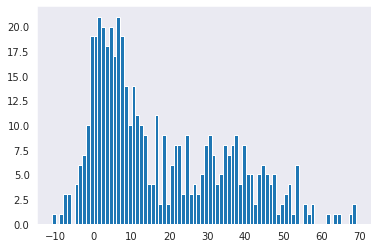

In [ ]:
plt.hist(data, bins=80)

xval = np.linspace(*data_range, 200)
# plt.plot(xval, 2*distribuition(xval))
# plt.plot(xval, 2*A1*gaussian(mu1, sig1, xval))
# plt.plot(xval, 2*A2*gaussian(mu2, sig2, xval))
plt.show()

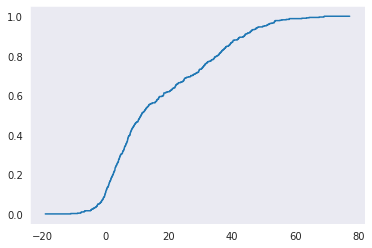

In [ ]:
x_train_data = np.linspace(*data_range, 10*Ntot)
y_train_data = np.array([countFunc(data, x) for x in x_train_data])
plt.plot(x_train_data, y_train_data)


## Fitting Sample

In [ ]:
compileArgs = {'loss':'mean_squared_error', 
               'optimizer':'Adam'}
trainParams     = {'epochs' : 300, 
               'batch_size' : 20, 
               'verbose' : 2}
model = None

Fitting Model
Epoch 1/300
250/250 - 0s - loss: 0.2077
Epoch 2/300
250/250 - 0s - loss: 0.1218
Epoch 3/300
250/250 - 0s - loss: 0.1133
Epoch 4/300
250/250 - 0s - loss: 0.1030
Epoch 5/300
250/250 - 0s - loss: 0.0898
Epoch 6/300
250/250 - 0s - loss: 0.0671
Epoch 7/300
250/250 - 0s - loss: 0.0382
Epoch 8/300
250/250 - 0s - loss: 0.0194
Epoch 9/300
250/250 - 0s - loss: 0.0064
Epoch 10/300
250/250 - 0s - loss: 0.0016
Epoch 11/300
250/250 - 0s - loss: 4.7788e-04
Epoch 12/300
250/250 - 0s - loss: 2.0798e-04
Epoch 13/300
250/250 - 0s - loss: 1.3539e-04
Epoch 14/300
250/250 - 0s - loss: 1.1037e-04
Epoch 15/300
250/250 - 0s - loss: 9.2385e-05
Epoch 16/300
250/250 - 0s - loss: 8.2173e-05
Epoch 17/300
250/250 - 0s - loss: 7.1727e-05
Epoch 18/300
250/250 - 0s - loss: 6.4791e-05
Epoch 19/300
250/250 - 0s - loss: 5.8907e-05
Epoch 20/300
250/250 - 0s - loss: 5.7520e-05
Epoch 21/300
250/250 - 0s - loss: 5.4330e-05
Epoch 22/300
250/250 - 0s - loss: 5.3805e-05
Epoch 23/300
250/250 - 0s - loss: 5.3772e-05


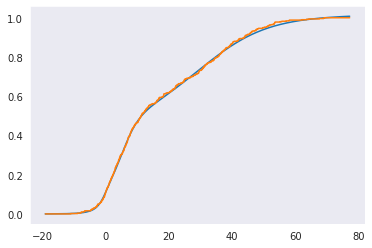

In [ ]:

model = getDistribuitionFitter_copy("model0", compileArgs)
histories = []


lossHistory = LossHistory( (x_train_data, y_train_data))
earlyStop = EarlyStopping(monitor="loss", patience=3, verbose=0, mode="auto")
# saveBest = ModelCheckpoint()

print("Fitting Model")
C = model.fit(x_train_data, y_train_data, **trainParams, callbacks=[lossHistory, earlyStop])
print("Finished Fitting")
histories.append(lossHistory.losses)

print("Loss : ", histories[-1]['loss'][-1])

xval = np.linspace(*data_range, 200) 
y_test = model.predict(xval)
plt.plot(xval, y_test)
plt.plot(x_train_data, y_train_data)

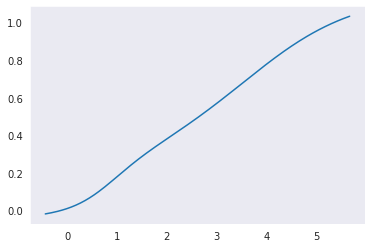

In [ ]:
xval = np.linspace(*data_range, 200) 
y_test = model.predict(xval)
plt.plot(xval, y_test)

# plt.plot(x_train_data, y_train_data)


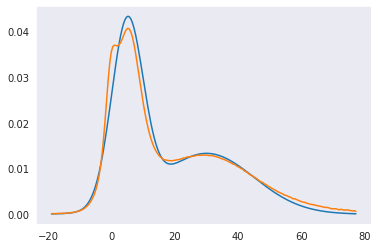

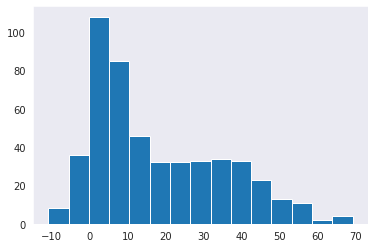

In [ ]:
h = 1.e-3
xval = np.linspace(*data_range, 200)
distr_model = (model.predict(xval+h) - model.predict(xval-h))/(2*h)


plt.plot(xval, distribuition(xval)/Ntot)
plt.plot(xval, distr_model)

plt.show()
plt.hist(data, bins=15)
plt.show()

Testing if its normalised

In [ ]:
dx = 1.e-3
int_xval = np.linspace(*data_range, int((data_range[1]-data_range[0])/dx) )
print(np.sum( ((model.predict(int_xval+h) - model.predict(int_xval-h))/(2*h))*dx ))


1.014849


# Multi-Gaussian random distribuition

In [ ]:
def gaussian(mu, sig, x):
    return 1./(np.sqrt(2*np.pi)*sig) * np.exp( -0.5*((x-mu)/sig)**2)

def multi_gauss_random(gauss_list, N=1):
    data = []
    for gauss in gauss_list:
        for i in range(int(N*gauss['A'])):
           data.append(np.random.normal(gauss['mu'], gauss['sig']))
    return np.array(data)

def multi_gauss_dist(gauss_list, x):
    dist = 0
    norm = 0
    for gauss in gauss_list:
        dist += gauss['A'] * gaussian(gauss['mu'], gauss['sig'], x)
        norm += gauss['A'] 
    return dist/norm


## Multi-Gaussian test

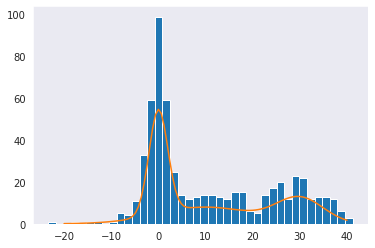

In [ ]:
gauss1 = {'A': 30, 'mu': 30, 'sig': 5}
gauss2 = {'A': 50, 'mu': 0, 'sig': 2}
gauss3 = {'A': 40, 'mu': 10, 'sig': 10}
gauss_list = [gauss1, gauss2, gauss3]
mult = 5
Ntot = mult*sum([gauss['A'] for gauss in gauss_list])
arr = multi_gauss_random(gauss_list, mult)

xval = np.linspace(-20,40, 100)
plt.hist(arr, bins=40)
plt.plot(xval, Ntot*multi_gauss_dist(gauss_list, xval))
plt.show()

# ----------------------------------------.

# Distribuition Fit Class

## Class Definition

In [6]:

class DistribuitionFit:

    # default parameters
    compileArgs = {'loss':'mean_squared_error', 
              'optimizer':'Adam'}
    
    trainParams     = {'epochs' : 3000, 
                   'batch_size' : 30, 
                      'verbose' : 2}

    netModel = None
    norm_const = 1
    x_train = None
    y_train = None
    xrange = (-1, 1)
    has_train = False
    h = 1.0e-3 # this value can change with Ntot and dataRange
    def __init__(self, compileArgs={}, trainParams={}, modelID='model1', weights=None, baseModel=None):
        for args in compileArgs:
            self.compileArgs[args] = compileArgs[args] 

        for params in trainParams:
            self.trainParams[params] = trainParams[params]

        if not baseModel:
            self.netModel = getDistribuitionFitter(modelID, self.compileArgs)
        else:
            self.netModel = clone_model(baseModel)
        
        if weights:
            self.netModel.set_weights(weights)
        
        # self.netModel.summary()

    def count(sortedData, x):
        for i in range(len(sortedData)):
            if x < sortedData[i]:
                return (i+0.)/(len(sortedData))
        return 1

    def train(self, data, xrange=None, h=None, trainParams=None ,verbose=0, xrange_excess=0, density=50, edge_density_mult=1, do_train=True): 
        # data:  raw, unsorted random data from some distribuition
        # xrange: range to fit
        # xrange_excess: extra range from the borders in percentage of total range
        # edge_fix: how much does the density increases at the excess zone
        data.sort()
        self.data = np.array(data)

        if not xrange:
            xrange = (data[0], data[-1])

        self.xrange0 = xrange

        xdelta_excess = (xrange[1]-xrange[0])*xrange_excess/2
        xdelta = (xrange[1]-xrange[0])/2 + xdelta_excess
        xcenter = (xrange[1]+xrange[0])/2
        self.xrange = (xcenter-xdelta, xcenter+xdelta)
       
        # the lower this value the more oscillations there are on the derivative
        if h == None:
            self.h = (self.xrange[1]-self.xrange[0])*1.0e-5
        else:
            self.h = h

        if not trainParams:
            trainParams = self.trainParams

        if do_train: # in case one only wants to initialise the data 
            N = len(data)

            arr = np.array([])
            # arr = np.append(arr, self.xrange[0]-xdelta_excess, self.xrange[0], 
            #                       edge_density_mult*xrange_excess*N))
            arr = np.append(arr, np.linspace(xrange[0]-xdelta_excess, xrange[0],
                                            int(N*density*edge_density_mult*xrange_excess)))
            arr = np.append(arr, np.linspace(*xrange, int(N*density)))
            arr = np.append(arr, np.linspace(xrange[1], xrange[1]+xdelta_excess, 
                                            int(N*density*edge_density_mult*xrange_excess)))

            self.x_train = np.unique(arr)

            self.y_train = np.array([DistribuitionFit.count(data, x) for x in self.x_train])

            lossHistory = LossHistory( (self.x_train, self.y_train))
            earlyStop = EarlyStopping(monitor="loss", patience=3, verbose=0, mode="auto")

            # print(len(self.x_train), len(self.y_train))
        
            c = self.netModel.fit(self.x_train, self.y_train, **trainParams, callbacks=[lossHistory, earlyStop])
            self.has_train=True
            if verbose==2:
                self.plotIntegratedComparison()

            return c 

    def normalise(self, dx=0, h=0):
        if dx==0: dx = self.h*10
        # print(*self.xrange, (self.xrange[1]-self.xrange[0])/dx)
        
        xval = np.linspace(*self.xrange, int((self.xrange[1]-self.xrange[0])/dx))
 
        self.norm_const = np.sum(self.probability_array(xval, h))*dx 

    def probability(self, x, h=0):
        if h==0: h = self.h 
        if x <= self.xrange0[0] or x >= self.xrange0[1]: # if its outside of range
            return 0
        p1, p0 = self.netModel.predict((x+h, x-h))
        val = (p1[0]-p0[0])/(2*h*self.norm_const)
        if val>0:
            return val
        else:
            return 0

    def probability_array(self, xarray, h=0):
        if h==0: h = self.h 

        arr_plus = np.array([v[0] for v in self.netModel.predict([x+h for x in xarray ])])
        arr_minus= np.array([v[0] for v in self.netModel.predict([x-h for x in xarray ])])

        temp = []
        for i,x in enumerate(xarray):
            if x <= self.xrange0[0] or x >= self.xrange0[1]:# if its outside of range
                temp.append(0)
            else:
                val = (arr_plus[i]-arr_minus[i])/(2*h*self.norm_const)
                if val<0:
                    temp.append(0)
                else:
                    temp.append(val)

        return np.array(temp)

    def plotIntegratedComparison(self):
        # plots the integrated histogram and its fit (direct output from fit)

        # plt.plot(x_train_data, y_train_data)
        if not self.has_train or not self.netModel:
            print(" Model hasn't yet trained! No data!")
            return
        xval = np.linspace(*self.xrange, 400)
        y_test = self.netModel.predict(xval)

        plt.plot(xval, y_test)
        plt.plot(self.x_train, self.y_train)

    def plotHist(self, xrange=(), histparams={}):
        # plots the data histogram
        if not xrange:
            xrange = self.xrange
        ax = sns.distplot(self.data, norm_hist = True, kde=False, **histparams)
        # plt.hist(self.csv_file[self.features[k]] , **params)
        if range:
            ax.set_xlim(*xrange)
        else:
            ax.set_xlim(*xrange)
        # plt.legend()
    
    def plotDistribuition(self, xrange=(), histparams={}, nPoints=200):
        # plots the probability values
        if not xrange:
            xrange = self.xrange
        xval = np.linspace(*xrange, nPoints)
        plt.plot(xval, self.probability_array(xval))
        
        

## Class Test

### Dummy Distribuitions Setup

In [ ]:
gauss_list = []

for mu in [-5,0,5]:
    for sig in [1,3,10]:
        for A in [75, 150, 300]:
            gauss_list.append( {'A':A, 'mu':mu, 'sig':sig} )


In [ ]:
xval = np.linspace(-40,40, 500)
glist1 = gauss_list[::11]

# plt.plot(xval, multi_gauss_dist(glist1, xval))
# plt.hist(multi_gauss_random(glist1), bins = 30)
# plt.show()

glist2 = gauss_list[::7]

# plt.hist(multi_gauss_random(glist2), bins = 30)
# plt.show()

### Fitting

In [ ]:
compileArgs = {'loss':'mean_squared_error', 
          'optimizer':'Adam'}
    
trainParams = {'epochs' : 3000,
            'batch_size' : 50, 
                'verbose' : 0}

In [ ]:

distModel1 = DistribuitionFit(compileArgs=compileArgs, trainParams=trainParams)

train0_data = [rand for rand in multi_gauss_random(glist1) if rand < -1.5]
train1_data = [rand for rand in multi_gauss_random(glist1) if rand < 0]
train2_data = [rand for rand in multi_gauss_random(glist1) if rand < 5]
train3_data =  multi_gauss_random(glist1)
train4_data = [rand for rand in multi_gauss_random(glist1) if rand > 2.5]

train_data2 = multi_gauss_random(glist2)

distModel1.train(train_data2, verbose=1)


KeyboardInterrupt: ignored

In [ ]:
print(type(np.array(train_data2)))
len(train_data2)

<class 'numpy.ndarray'>


600

Epoch 1/3000
11/11 - 0s - loss: 0.1282
Epoch 2/3000
11/11 - 0s - loss: 0.0862
Epoch 3/3000
11/11 - 0s - loss: 0.0604
Epoch 4/3000
11/11 - 0s - loss: 0.0448
Epoch 5/3000
11/11 - 0s - loss: 0.0330
Epoch 6/3000
11/11 - 0s - loss: 0.0253
Epoch 7/3000
11/11 - 0s - loss: 0.0191
Epoch 8/3000
11/11 - 0s - loss: 0.0147
Epoch 9/3000
11/11 - 0s - loss: 0.0109
Epoch 10/3000
11/11 - 0s - loss: 0.0081
Epoch 11/3000
11/11 - 0s - loss: 0.0061
Epoch 12/3000
11/11 - 0s - loss: 0.0047
Epoch 13/3000
11/11 - 0s - loss: 0.0036
Epoch 14/3000
11/11 - 0s - loss: 0.0028
Epoch 15/3000
11/11 - 0s - loss: 0.0023
Epoch 16/3000
11/11 - 0s - loss: 0.0019
Epoch 17/3000
11/11 - 0s - loss: 0.0016
Epoch 18/3000
11/11 - 0s - loss: 0.0014
Epoch 19/3000
11/11 - 0s - loss: 0.0012
Epoch 20/3000
11/11 - 0s - loss: 0.0011
Epoch 21/3000
11/11 - 0s - loss: 0.0010
Epoch 22/3000
11/11 - 0s - loss: 9.2720e-04
Epoch 23/3000
11/11 - 0s - loss: 8.5898e-04
Epoch 24/3000
11/11 - 0s - loss: 8.0849e-04
Epoch 25/3000
11/11 - 0s - loss: 7.65

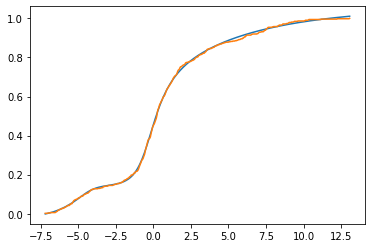

In [ ]:
distModel1.train(train3_data, verbose=1) 

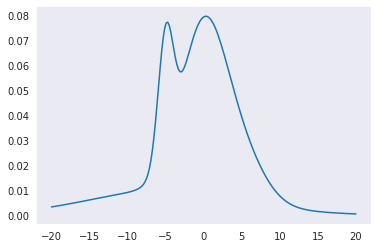

In [ ]:
xval = np.linspace(-20,20, 200)

distval = multi_gauss_dist(glist2, xval)
# netval = distModel1.probability(xval)

# plt.plot(xval, netval)
plt.plot(xval, distval)
plt.show()

In the case that the distribuition fit is not closing in on the data as wanted, a way around it is to successively fit the data with more and more points, and choosing them on an increasingly bigger range.
The initial range should be choosen on the region which is hardest to fit

# Fitting Neutralinos and Noise 

-- Requires Tabs

*   Imports
*   Neural Nets functions
*   Callbacks
*   Distribuition Fit Class [Class Definition]



In [ ]:
!git clone https://github.com/Rualito/ShipAnalysis
!git clone https://github.com/Switch-bot/SHiP-Data

Cloning into 'ShipAnalysis'...
remote: Enumerating objects: 117, done.
remote: Counting objects: 100% (117/117), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 117 (delta 18), reused 111 (delta 15), pack-reused 0
Receiving objects: 100% (117/117), 1.96 MiB | 3.97 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Cloning into 'SHiP-Data'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 53 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (53/53), done.


## Choosing file and Loading data arrays

In [8]:
# Decays ->  [1] ('pi pi', 'pi mu') [2] ('K mu', 'mu mu')

# susy = 1, 2
# decay = [susy=1] ('pi pi', 'pi mu') [susy=2] ('K mu', 'mu mu')
# Nmass = 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 'All'
decay_select = { 'susy':2, 
                'decay':'K mu', 
                'Nmass':'All'}

all_signal_ID = {}

for Nmass in [0.6,0.8,1.0,1.2,1.4,1.6]:
    all_signal_ID[Nmass] = {}
    
    all_signal_ID[Nmass][1] = {}
    all_signal_ID[Nmass][1]['pi pi'] = ("pi- pi+ ")
    all_signal_ID[Nmass][1]['pi mu'] = ("pi- mu+ ", "mu- pi+ ")

    all_signal_ID[Nmass][2] = {}
    all_signal_ID[Nmass][2]['K mu'] = ("K- mu+ ", "mu- K+ ")
    all_signal_ID[Nmass][2]['mu mu'] =("mu+ mu- ")

signal_files = []
background_files = []

background_types = ['e', 'e_bar', 'mu', 'mu_bar']

if decay_select['Nmass'] == 'All':
    for nmass in [0.6, 0.8, 1.0, 1.2, 1.4, 1.6]:
        susy = decay_select['susy']
        decay_type = decay_select['decay']
        for dec in all_signal_ID[ nmass ][ susy ][ decay_type ]:
            signal_files.append("ShipAnalysis/NeutralinoDecayData/decay3/SfMass=1000/N0Mass={0}/susyBench{1}/kinematic_variables_{2}.dat".format(nmass, susy, dec))
            for backtype in background_types:
                background_files.append("SHiP-Data/Raul/{0}/kinematic_variables_{1}.dat".format(backtype, dec))
else:
    nmass = decay_select['Nmass']
    susy = decay_select['susy']
    decay_type = decay_select['decay']
    for dec in all_signal_ID[ nmass ][ susy ][ decay_type ]:
        signal_files.append("ShipAnalysis/NeutralinoDecayData/decay3/SfMass=1000/N0Mass={0}/susyBench{1}/kinematic_variables_{2}.dat".format(nmass, susy, dec))
        for backtype in background_types:
                background_files.append("SHiP-Data/Raul/{0}/kinematic_variables_{1}.dat".format(backtype, dec))

def read_csvs_and_concat(filename_list):
    file_list = []
    for filename in filename_list:
        file_list.append(pandas.read_csv(filename))
    
    return pandas.concat(file_list)

FullSignal_file = read_csvs_and_concat(signal_files)
FullBackground_file = read_csvs_and_concat(background_files)

print(len(FullSignal_file))
print(len(FullBackground_file))


3539
552


In [9]:
# defaults
compileArgs = {'loss':'mean_squared_error', 
          'optimizer':'Adam'}
    
trainParams = {'epochs' : 150,
            'batch_size' : 10, 
                'verbose' : 2}

all_features = {}
for i,name in enumerate(FullSignal_file.columns):
    all_features[i] = name
print(all_features)


{0: 'Mother Total Momentum (GeV/c)', 1: ' Mother Transverse Momentum (GeV/c)', 2: ' Mother Fraction of Transverse Momentum', 3: ' Opening Angle (rad)', 4: ' Decay Angle (rad)', 5: ' Impact Parameter (cm)', 6: ' Daughter1 Total Momentum (GeV/c)', 7: ' Daughter1 Transverse Momentum (GeV/c)', 8: ' Daughter1 Fraction of Transverse Momentum', 9: ' Daughter2 Total Momentum (GeV/c)', 10: ' Daughter2 Transverse Momentum (GeV/c)', 11: ' Daughter2 Fraction of Transverse Momentum', 12: ' Decay Z (cm)', 13: ' Decay X (cm)', 14: ' Decay Y (cm)', 15: ' Event type'}


## Choosing features

In [10]:

selected_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14]

feature_names = [all_features[i] for i in selected_features]

# print(len(mf_signal.dev_data[feature_names[0]]), len(mf_background.dev_data[feature_names[0]]))


In [17]:
dirname = "/content/drive/My Drive/Neutralinos/Network Saves/"
filename_signal = "{}/signal-{}/".format(dirname, decay_select['decay'])
filename_background = "{}/background-{}/".format(dirname, decay_select['decay'])


## Managing data and applying Distribuition Fitting

### MultiFeature fit class

In [26]:
# default ranges: (-1, 1) for all except: Impact Parameter -> (-1, 10)


class MultiFeature :
    
    # default parameters = {}
    compileArgs = {'loss':'mean_squared_error', 
            'optimizer':'Adam'}
        
    trainParams = {'epochs' : 100,
                'batch_size' : 50, 
                    'verbose' : 2}

    trainParams_getfile = {'epochs' : 1,
                'batch_size' : 50, 
                    'verbose' : 0}

    fitParams_getfile = {'verbose':2, 
                    'xrange_excess': 0.2,
                    'density': 0,
                    'edge_density_mult':3}

    distfit_array = None
    features = []
    csv_file = None
    dev_data = None
    val_data = None

    def __init__(self, csv_file, features, parameters={}, xrange=None):
        # features: list of strings
        self.csv_file = csv_file
        self.features = features 
        trainParams = {}
        compileArgs = {}

        self.dev_data = {}
        self.val_data = {}
        self.distfit_array = {}

        if 'trainParams' in parameters:
            for pars in parameters['trainParams']:
                if pars in parameters['trainParams']:
                    self.trainParams[pars] = parameters['trainParams'][pars]
        
        if 'compileArgs' in parameters:
            for args in parameters['compileArgs']:
                if args in parameters['compileArgs']:
                    self.compileArgs[args] = parameters['compileArgs'][args]
        
        

        # self.distfit = DistribuitionFit(trainParams=self.trainParams, compileArgs=self.compileArgs)
        for k, feat in enumerate(features):
            param_model = "model_{}".format(k)
            if param_model in parameters:
                self.distfit_array[feat] = DistribuitionFit(trainParams=self.trainParams, 
                                                            compileArgs=self.compileArgs, modelID=parameters[param_model])
            else:
                self.distfit_array[feat] = DistribuitionFit(trainParams=self.trainParams, 
                                                            compileArgs=self.compileArgs)
            # a,b = train_test_split(self.csv_file[feat], test_size=split)
            self.dev_data[feat] = self.csv_file[feat]
            # self.val_data[feat] = b
            # print(feat, len(self.dev_data[feat]), len(self.val_data[feat]))
        
        if xrange:
            self.normalise_ranges(xrange)

    def fitFeature(self, k, fitParams={}, trainParams=None):
        feat = self.features[k]
        if not trainParams:
            trainParams = self.trainParams
        self.distfit_array[feat].train(self.dev_data[feat].to_numpy(), **fitParams, trainParams=trainParams)
        self.distfit_array[feat].normalise()
        
        print(k, ' Finished fitting ', feat)
        
    def resetFit(self,k, modelID=None):
        feat = self.features[k]
        if not modelID:
            self.distfit_array[feat] = DistribuitionFit(self.compileArgs, self.trainParams)
        else:
            self.distfit_array[feat] = DistribuitionFit(self.compileArgs, self.trainParams, modelID)

    def normalise_ranges(self, xrange=(-1, 1)):
        # normalise dev_data and val_data
        x_delta = xrange[1]-xrange[0]
        for feat in self.features:
            dev_max = np.max(self.dev_data[feat])
            dev_min = np.min(self.dev_data[feat])
            
            dev_delta = dev_max - dev_min
            
            self.dev_data[feat] = (self.dev_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
            # self.val_data[feat] = (self.val_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
    
    def normalise_range(self, k, xrange=(-1, 1)):
        # normalise dev_data and val_data
        feat = self.features[k]
        x_delta = xrange[1]-xrange[0]
        
        dev_max = np.max(self.dev_data[feat])
        dev_min = np.min(self.dev_data[feat])
        
        dev_delta = dev_max - dev_min
        
        self.dev_data[feat] = (self.dev_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
        # self.val_data[feat] = (self.val_data[feat]-dev_min)*x_delta/dev_delta + xrange[0]
    
    def save_distribuitions_to_file(self, dirname):
        if not os.path.isdir(dirname):
            os.makedirs(dirname)
        for feat in self.features:
            filename = "{}\\feature-{}.h5".format(dirname, feat.replace("/", "_"))
            self.distfit_array[feat].netModel.save(filename)
    
    def get_distribuitions_from_file(self, dirname, verbose=0):
        # make sure to set the ranges to the right values
        for k,feat in enumerate(self.features):
            if verbose==1:
                print("Loading model ", feat)
            filename = "{}\\feature-{}.h5".format(dirname, feat.replace("/", "_"))
            if not os.path.exists(filename):
                print("weight file ", filename, " doesn't exist")
            self.distfit_array[feat].netModel = load_model(filename, compile = False)
            self.fitFeature(k, {'do_train':False})
            self.distfit_array[feat].normalise()

    def drawFeatureHist(self, k, params={}, xrange=()):
        self.distfit_array[self.features[k]].plotHist(xrange, params)
        
    def fitAll(self, fitParams, trainParams=None):
        if trainParams:
            for k,feat in enumerate(self.features):
                self.fitFeature(k, fitParams, trainParams=trainParams)
                if 'verbose' in fitParams and fitParams['verbose']==2:
                    plt.show()
        else:
            for k,feat in enumerate(self.features):
                self.fitFeature(k, fitParams)
                if 'verbose' in fitParams and fitParams['verbose']==2:
                    plt.show()

    def drawDistComparison(self, k, params={}, xrange=()):
        # compares the distribuition (probability) to the histogram
        self.drawFeatureHist(k, params, xrange)
        self.distfit_array[self.features[k]].plotDistribuition(xrange, params)


## Fitting the signal data

In [12]:
compileArgs = {'loss':'mean_squared_error', 
          'optimizer':'Adam'}
    

trainParams = {'epochs' : 150,
            'batch_size' : 10, 
                'verbose' : 2}

Epoch 1/150
779/779 - 2s - loss: 0.2475
Epoch 2/150
779/779 - 2s - loss: 0.1429
Epoch 3/150
779/779 - 1s - loss: 0.0397
Epoch 4/150
779/779 - 1s - loss: 0.0047
Epoch 5/150
779/779 - 1s - loss: 0.0010
Epoch 6/150
779/779 - 1s - loss: 5.0321e-04
Epoch 7/150
779/779 - 1s - loss: 2.0654e-04
Epoch 8/150
779/779 - 1s - loss: 1.9142e-04
Epoch 9/150
779/779 - 1s - loss: 1.8280e-04
Epoch 10/150
779/779 - 1s - loss: 1.7570e-04
Epoch 11/150
779/779 - 1s - loss: 1.6368e-04
Epoch 12/150
779/779 - 1s - loss: 1.5545e-04
Epoch 13/150
779/779 - 1s - loss: 1.4533e-04
Epoch 14/150
779/779 - 1s - loss: 1.3649e-04
Epoch 15/150
779/779 - 1s - loss: 1.2803e-04
Epoch 16/150
779/779 - 1s - loss: 1.1903e-04
Epoch 17/150
779/779 - 1s - loss: 1.1136e-04
Epoch 18/150
779/779 - 1s - loss: 1.0306e-04
Epoch 19/150
779/779 - 1s - loss: 9.3859e-05
Epoch 20/150
779/779 - 1s - loss: 8.4570e-05
Epoch 21/150
779/779 - 1s - loss: 7.8413e-05
Epoch 22/150
779/779 - 1s - loss: 6.9695e-05
Epoch 23/150
779/779 - 1s - loss: 6.550

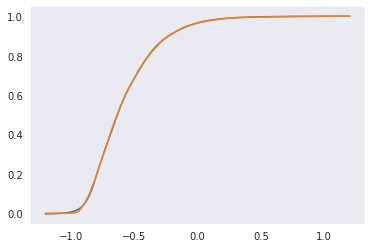

Epoch 1/150
779/779 - 1s - loss: 0.2192
Epoch 2/150
779/779 - 1s - loss: 0.1282
Epoch 3/150
779/779 - 1s - loss: 0.0293
Epoch 4/150
779/779 - 1s - loss: 0.0029
Epoch 5/150
779/779 - 1s - loss: 9.3521e-04
Epoch 6/150
779/779 - 1s - loss: 5.8499e-04
Epoch 7/150
779/779 - 1s - loss: 2.1126e-04
Epoch 8/150
779/779 - 1s - loss: 1.4975e-04
Epoch 9/150
779/779 - 1s - loss: 1.4069e-04
Epoch 10/150
779/779 - 1s - loss: 1.3205e-04
Epoch 11/150
779/779 - 1s - loss: 1.1953e-04
Epoch 12/150
779/779 - 1s - loss: 1.0975e-04
Epoch 13/150
779/779 - 1s - loss: 9.9337e-05
Epoch 14/150
779/779 - 1s - loss: 9.1314e-05
Epoch 15/150
779/779 - 1s - loss: 8.5542e-05
Epoch 16/150
779/779 - 1s - loss: 8.2046e-05
Epoch 17/150
779/779 - 1s - loss: 7.6433e-05
Epoch 18/150
779/779 - 1s - loss: 7.2725e-05
Epoch 19/150
779/779 - 1s - loss: 6.8355e-05
Epoch 20/150
779/779 - 1s - loss: 6.4459e-05
Epoch 21/150
779/779 - 1s - loss: 6.0469e-05
Epoch 22/150
779/779 - 1s - loss: 5.8106e-05
Epoch 23/150
779/779 - 1s - loss: 5

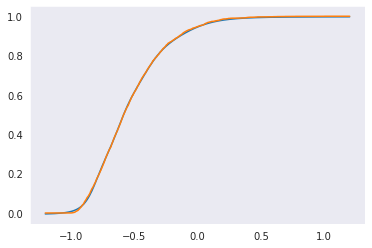

Epoch 1/150
779/779 - 1s - loss: 0.2240
Epoch 2/150
779/779 - 1s - loss: 0.1173
Epoch 3/150
779/779 - 1s - loss: 0.0200
Epoch 4/150
779/779 - 1s - loss: 0.0031
Epoch 5/150
779/779 - 1s - loss: 6.8730e-04
Epoch 6/150
779/779 - 1s - loss: 9.0397e-05
Epoch 7/150
779/779 - 1s - loss: 5.2853e-05
Epoch 8/150
779/779 - 1s - loss: 4.8613e-05
Epoch 9/150
779/779 - 1s - loss: 4.6041e-05
Epoch 10/150
779/779 - 1s - loss: 4.4024e-05
Epoch 11/150
779/779 - 1s - loss: 4.2373e-05
Epoch 12/150
779/779 - 1s - loss: 3.9390e-05
Epoch 13/150
779/779 - 1s - loss: 3.5865e-05
Epoch 14/150
779/779 - 1s - loss: 3.3635e-05
Epoch 15/150
779/779 - 1s - loss: 3.0094e-05
Epoch 16/150
779/779 - 1s - loss: 2.8155e-05
Epoch 17/150
779/779 - 1s - loss: 2.6249e-05
Epoch 18/150
779/779 - 1s - loss: 2.4030e-05
Epoch 19/150
779/779 - 1s - loss: 2.2784e-05
Epoch 20/150
779/779 - 1s - loss: 2.1705e-05
Epoch 21/150
779/779 - 1s - loss: 2.0325e-05
Epoch 22/150
779/779 - 1s - loss: 1.9995e-05
Epoch 23/150
779/779 - 1s - loss: 1

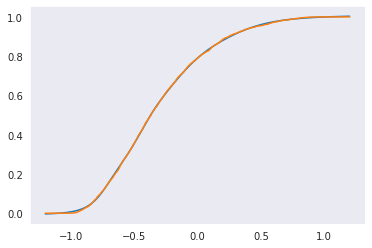

Epoch 1/150
779/779 - 1s - loss: 0.2371
Epoch 2/150
779/779 - 1s - loss: 0.1505
Epoch 3/150
779/779 - 1s - loss: 0.0646
Epoch 4/150
779/779 - 1s - loss: 0.0147
Epoch 5/150
779/779 - 1s - loss: 0.0022
Epoch 6/150
779/779 - 1s - loss: 7.1429e-04
Epoch 7/150
779/779 - 1s - loss: 6.2935e-04
Epoch 8/150
779/779 - 1s - loss: 6.2647e-04
Epoch 9/150
779/779 - 1s - loss: 6.2818e-04
Epoch 10/150
779/779 - 1s - loss: 6.2700e-04
Epoch 11/150
779/779 - 1s - loss: 6.1763e-04
Epoch 12/150
779/779 - 1s - loss: 6.0352e-04
Epoch 13/150
779/779 - 1s - loss: 5.5757e-04
Epoch 14/150
779/779 - 1s - loss: 5.0656e-04
Epoch 15/150
779/779 - 1s - loss: 4.5827e-04
Epoch 16/150
779/779 - 1s - loss: 4.1801e-04
Epoch 17/150
779/779 - 1s - loss: 3.9297e-04
Epoch 18/150
779/779 - 1s - loss: 3.7263e-04
Epoch 19/150
779/779 - 1s - loss: 3.6127e-04
Epoch 20/150
779/779 - 1s - loss: 3.4994e-04
Epoch 21/150
779/779 - 1s - loss: 3.3891e-04
Epoch 22/150
779/779 - 1s - loss: 3.2654e-04
Epoch 23/150
779/779 - 1s - loss: 3.168

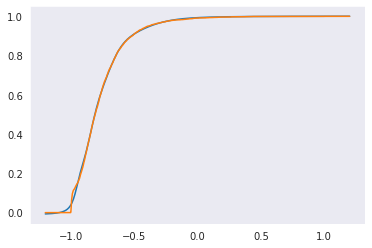

Epoch 1/150
779/779 - 1s - loss: 0.2460
Epoch 2/150
779/779 - 1s - loss: 0.0925
Epoch 3/150
779/779 - 1s - loss: 0.0294
Epoch 4/150
779/779 - 1s - loss: 0.0074
Epoch 5/150
779/779 - 1s - loss: 0.0033
Epoch 6/150
779/779 - 1s - loss: 0.0028
Epoch 7/150
779/779 - 1s - loss: 0.0026
Epoch 8/150
779/779 - 1s - loss: 0.0024
Epoch 9/150
779/779 - 1s - loss: 0.0022
Epoch 10/150
779/779 - 1s - loss: 0.0021
Epoch 11/150
779/779 - 1s - loss: 0.0019
Epoch 12/150
779/779 - 2s - loss: 0.0018
Epoch 13/150
779/779 - 2s - loss: 0.0017
Epoch 14/150
779/779 - 2s - loss: 0.0016
Epoch 15/150
779/779 - 1s - loss: 0.0015
Epoch 16/150
779/779 - 1s - loss: 0.0014
Epoch 17/150
779/779 - 1s - loss: 0.0013
Epoch 18/150
779/779 - 1s - loss: 0.0013
Epoch 19/150
779/779 - 1s - loss: 0.0012
Epoch 20/150
779/779 - 1s - loss: 0.0011
Epoch 21/150
779/779 - 1s - loss: 0.0011
Epoch 22/150
779/779 - 1s - loss: 9.9686e-04
Epoch 23/150
779/779 - 1s - loss: 9.5938e-04
Epoch 24/150
779/779 - 1s - loss: 9.1026e-04
Epoch 25/150


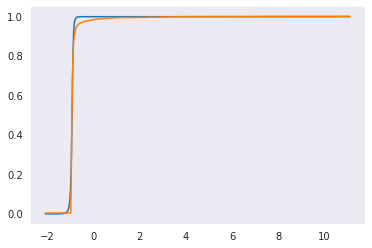

Epoch 1/150
779/779 - 1s - loss: 0.2274
Epoch 2/150
779/779 - 1s - loss: 0.1435
Epoch 3/150
779/779 - 1s - loss: 0.0520
Epoch 4/150
779/779 - 1s - loss: 0.0102
Epoch 5/150
779/779 - 1s - loss: 0.0019
Epoch 6/150
779/779 - 1s - loss: 0.0011
Epoch 7/150
779/779 - 1s - loss: 0.0010
Epoch 8/150
779/779 - 1s - loss: 0.0010
Epoch 9/150
779/779 - 1s - loss: 8.6979e-04
Epoch 10/150
779/779 - 1s - loss: 6.9458e-04
Epoch 11/150
779/779 - 1s - loss: 6.4009e-04
Epoch 12/150
779/779 - 1s - loss: 6.0399e-04
Epoch 13/150
779/779 - 1s - loss: 5.7401e-04
Epoch 14/150
779/779 - 1s - loss: 5.5056e-04
Epoch 15/150
779/779 - 1s - loss: 5.3196e-04
Epoch 16/150
779/779 - 1s - loss: 5.1606e-04
Epoch 17/150
779/779 - 1s - loss: 4.9842e-04
Epoch 18/150
779/779 - 1s - loss: 4.7843e-04
Epoch 19/150
779/779 - 1s - loss: 4.6194e-04
Epoch 20/150
779/779 - 1s - loss: 4.4461e-04
Epoch 21/150
779/779 - 1s - loss: 4.2939e-04
Epoch 22/150
779/779 - 1s - loss: 4.1375e-04
Epoch 23/150
779/779 - 1s - loss: 4.0202e-04
Epoch 

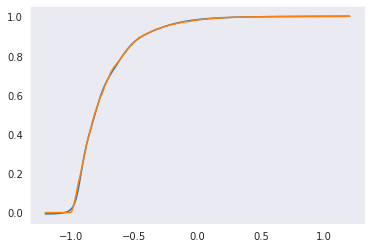

Epoch 1/150
779/779 - 1s - loss: 0.2376
Epoch 2/150
779/779 - 1s - loss: 0.1465
Epoch 3/150
779/779 - 1s - loss: 0.0450
Epoch 4/150
779/779 - 1s - loss: 0.0055
Epoch 5/150
779/779 - 1s - loss: 0.0015
Epoch 6/150
779/779 - 1s - loss: 8.0711e-04
Epoch 7/150
779/779 - 1s - loss: 2.1986e-04
Epoch 8/150
779/779 - 1s - loss: 1.7428e-04
Epoch 9/150
779/779 - 1s - loss: 1.6871e-04
Epoch 10/150
779/779 - 1s - loss: 1.6454e-04
Epoch 11/150
779/779 - 1s - loss: 1.6046e-04
Epoch 12/150
779/779 - 1s - loss: 1.5451e-04
Epoch 13/150
779/779 - 1s - loss: 1.4980e-04
Epoch 14/150
779/779 - 1s - loss: 1.4658e-04
Epoch 15/150
779/779 - 1s - loss: 1.4098e-04
Epoch 16/150
779/779 - 1s - loss: 1.3904e-04
Epoch 17/150
779/779 - 1s - loss: 1.3287e-04
Epoch 18/150
779/779 - 1s - loss: 1.2917e-04
Epoch 19/150
779/779 - 1s - loss: 1.2228e-04
Epoch 20/150
779/779 - 1s - loss: 1.2115e-04
Epoch 21/150
779/779 - 1s - loss: 1.1513e-04
Epoch 22/150
779/779 - 1s - loss: 1.0916e-04
Epoch 23/150
779/779 - 1s - loss: 1.058

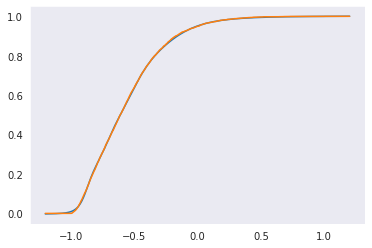

Epoch 1/150
779/779 - 1s - loss: 0.2257
Epoch 2/150
779/779 - 1s - loss: 0.1597
Epoch 3/150
779/779 - 1s - loss: 0.0806
Epoch 4/150
779/779 - 1s - loss: 0.0191
Epoch 5/150
779/779 - 1s - loss: 0.0032
Epoch 6/150
779/779 - 1s - loss: 9.6772e-04
Epoch 7/150
779/779 - 1s - loss: 8.0884e-04
Epoch 8/150
779/779 - 1s - loss: 7.8978e-04
Epoch 9/150
779/779 - 1s - loss: 7.7176e-04
Epoch 10/150
779/779 - 1s - loss: 7.6077e-04
Epoch 11/150
779/779 - 1s - loss: 7.4538e-04
Epoch 12/150
779/779 - 1s - loss: 7.2848e-04
Epoch 13/150
779/779 - 1s - loss: 7.1402e-04
Epoch 14/150
779/779 - 1s - loss: 7.0493e-04
Epoch 15/150
779/779 - 1s - loss: 7.0203e-04
Epoch 16/150
779/779 - 1s - loss: 6.8939e-04
Epoch 17/150
779/779 - 1s - loss: 6.7623e-04
Epoch 18/150
779/779 - 1s - loss: 6.6275e-04
Epoch 19/150
779/779 - 1s - loss: 6.4066e-04
Epoch 20/150
779/779 - 1s - loss: 5.9519e-04
Epoch 21/150
779/779 - 1s - loss: 5.1949e-04
Epoch 22/150
779/779 - 1s - loss: 4.5460e-04
Epoch 23/150
779/779 - 1s - loss: 4.085

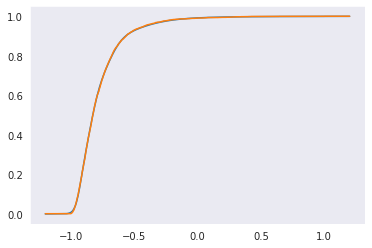

Epoch 1/150
779/779 - 1s - loss: 0.2359
Epoch 2/150
779/779 - 1s - loss: 0.1474
Epoch 3/150
779/779 - 1s - loss: 0.0515
Epoch 4/150
779/779 - 1s - loss: 0.0085
Epoch 5/150
779/779 - 1s - loss: 0.0012
Epoch 6/150
779/779 - 1s - loss: 7.1463e-04
Epoch 7/150
779/779 - 1s - loss: 6.7573e-04
Epoch 8/150
779/779 - 1s - loss: 5.9546e-04
Epoch 9/150
779/779 - 1s - loss: 4.8478e-04
Epoch 10/150
779/779 - 1s - loss: 4.3826e-04
Epoch 11/150
779/779 - 1s - loss: 4.0704e-04
Epoch 12/150
779/779 - 1s - loss: 3.8965e-04
Epoch 13/150
779/779 - 1s - loss: 3.7066e-04
Epoch 14/150
779/779 - 1s - loss: 3.5413e-04
Epoch 15/150
779/779 - 1s - loss: 3.4053e-04
Epoch 16/150
779/779 - 1s - loss: 3.1763e-04
Epoch 17/150
779/779 - 1s - loss: 3.0996e-04
Epoch 18/150
779/779 - 1s - loss: 2.9434e-04
Epoch 19/150
779/779 - 1s - loss: 2.7804e-04
Epoch 20/150
779/779 - 1s - loss: 2.6442e-04
Epoch 21/150
779/779 - 1s - loss: 2.5405e-04
Epoch 22/150
779/779 - 1s - loss: 2.4591e-04
Epoch 23/150
779/779 - 1s - loss: 2.331

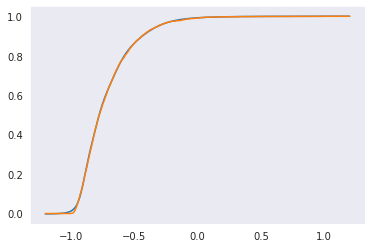

Epoch 1/150
779/779 - 1s - loss: 0.2261
Epoch 2/150
779/779 - 1s - loss: 0.1374
Epoch 3/150
779/779 - 1s - loss: 0.0374
Epoch 4/150
779/779 - 1s - loss: 0.0040
Epoch 5/150
779/779 - 1s - loss: 8.8266e-04
Epoch 6/150
779/779 - 1s - loss: 6.6901e-04
Epoch 7/150
779/779 - 1s - loss: 3.9445e-04
Epoch 8/150
779/779 - 1s - loss: 1.8393e-04
Epoch 9/150
779/779 - 1s - loss: 1.6965e-04
Epoch 10/150
779/779 - 1s - loss: 1.6307e-04
Epoch 11/150
779/779 - 1s - loss: 1.5360e-04
Epoch 12/150
779/779 - 1s - loss: 1.4297e-04
Epoch 13/150
779/779 - 1s - loss: 1.3144e-04
Epoch 14/150
779/779 - 1s - loss: 1.1997e-04
Epoch 15/150
779/779 - 1s - loss: 1.1048e-04
Epoch 16/150
779/779 - 1s - loss: 1.0193e-04
Epoch 17/150
779/779 - 1s - loss: 9.5470e-05
Epoch 18/150
779/779 - 1s - loss: 9.1454e-05
Epoch 19/150
779/779 - 1s - loss: 8.6782e-05
Epoch 20/150
779/779 - 1s - loss: 8.2432e-05
Epoch 21/150
779/779 - 1s - loss: 7.8258e-05
Epoch 22/150
779/779 - 1s - loss: 7.4692e-05
Epoch 23/150
779/779 - 1s - loss: 7

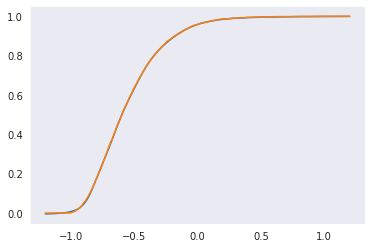

Epoch 1/150
779/779 - 1s - loss: 0.2216
Epoch 2/150
779/779 - 1s - loss: 0.1618
Epoch 3/150
779/779 - 1s - loss: 0.0752
Epoch 4/150
779/779 - 1s - loss: 0.0097
Epoch 5/150
779/779 - 1s - loss: 0.0015
Epoch 6/150
779/779 - 1s - loss: 0.0011
Epoch 7/150
779/779 - 1s - loss: 0.0010
Epoch 8/150
779/779 - 1s - loss: 9.6247e-04
Epoch 9/150
779/779 - 1s - loss: 9.1530e-04
Epoch 10/150
779/779 - 1s - loss: 8.7024e-04
Epoch 11/150
779/779 - 1s - loss: 8.3005e-04
Epoch 12/150
779/779 - 1s - loss: 7.9746e-04
Epoch 13/150
779/779 - 1s - loss: 7.5176e-04
Epoch 14/150
779/779 - 1s - loss: 7.2036e-04
Epoch 15/150
779/779 - 1s - loss: 6.9597e-04
Epoch 16/150
779/779 - 1s - loss: 6.7186e-04
Epoch 17/150
779/779 - 1s - loss: 6.4759e-04
Epoch 18/150
779/779 - 1s - loss: 6.3192e-04
Epoch 19/150
779/779 - 1s - loss: 6.2430e-04
Epoch 20/150
779/779 - 1s - loss: 6.1003e-04
Epoch 21/150
779/779 - 1s - loss: 5.9537e-04
Epoch 22/150
779/779 - 1s - loss: 5.8755e-04
Epoch 23/150
779/779 - 1s - loss: 5.7796e-04
Ep

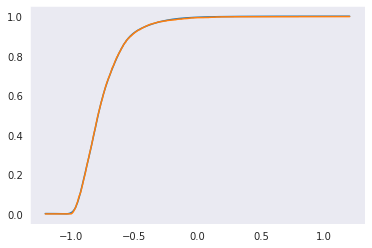

Epoch 1/150
779/779 - 1s - loss: 0.1939
Epoch 2/150
779/779 - 1s - loss: 0.1038
Epoch 3/150
779/779 - 1s - loss: 0.0149
Epoch 4/150
779/779 - 1s - loss: 0.0033
Epoch 5/150
779/779 - 1s - loss: 3.8661e-04
Epoch 6/150
779/779 - 1s - loss: 1.6361e-04
Epoch 7/150
779/779 - 1s - loss: 1.5116e-04
Epoch 8/150
779/779 - 1s - loss: 1.4680e-04
Epoch 9/150
779/779 - 1s - loss: 1.4265e-04
Epoch 10/150
779/779 - 1s - loss: 1.4177e-04
Epoch 11/150
779/779 - 1s - loss: 1.3625e-04
Epoch 12/150
779/779 - 1s - loss: 1.3923e-04
Epoch 13/150
779/779 - 1s - loss: 1.3595e-04
Epoch 14/150
779/779 - 1s - loss: 1.3691e-04
Epoch 15/150
779/779 - 1s - loss: 1.2905e-04
Epoch 16/150
779/779 - 1s - loss: 1.3189e-04
Epoch 17/150
779/779 - 1s - loss: 1.2773e-04
Epoch 18/150
779/779 - 1s - loss: 1.2871e-04
Epoch 19/150
779/779 - 1s - loss: 1.2592e-04
Epoch 20/150
779/779 - 1s - loss: 1.2585e-04
Epoch 21/150
779/779 - 1s - loss: 1.2435e-04
Epoch 22/150
779/779 - 1s - loss: 1.2158e-04
Epoch 23/150
779/779 - 1s - loss: 1

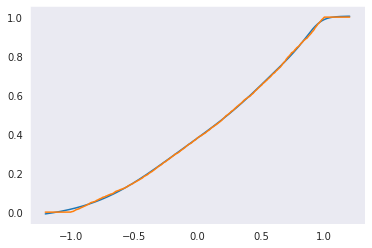

Epoch 1/150
779/779 - 1s - loss: 0.2173
Epoch 2/150
779/779 - 1s - loss: 0.1479
Epoch 3/150
779/779 - 1s - loss: 0.0247
Epoch 4/150
779/779 - 1s - loss: 0.0020
Epoch 5/150
779/779 - 1s - loss: 3.3784e-04
Epoch 6/150
779/779 - 1s - loss: 2.4600e-05
Epoch 7/150
779/779 - 1s - loss: 1.8801e-05
Epoch 8/150
779/779 - 1s - loss: 1.6834e-05
Epoch 9/150
779/779 - 1s - loss: 1.4577e-05
Epoch 10/150
779/779 - 1s - loss: 1.2399e-05
Epoch 11/150
779/779 - 1s - loss: 1.0480e-05
Epoch 12/150
779/779 - 1s - loss: 9.8451e-06
Epoch 13/150
779/779 - 1s - loss: 9.6076e-06
Epoch 14/150
779/779 - 1s - loss: 9.2601e-06
Epoch 15/150
779/779 - 1s - loss: 9.5022e-06
Epoch 16/150
779/779 - 1s - loss: 9.6883e-06
Epoch 17/150
779/779 - 1s - loss: 9.7252e-06
12  Finished fitting   Decay X (cm)


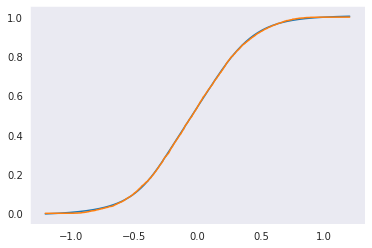

Epoch 1/150
779/779 - 1s - loss: 0.2151
Epoch 2/150
779/779 - 1s - loss: 0.1162
Epoch 3/150
779/779 - 1s - loss: 0.0108
Epoch 4/150
779/779 - 1s - loss: 5.2269e-04
Epoch 5/150
779/779 - 1s - loss: 1.5607e-04
Epoch 6/150
779/779 - 1s - loss: 2.7985e-05
Epoch 7/150
779/779 - 1s - loss: 1.7184e-05
Epoch 8/150
779/779 - 1s - loss: 1.1524e-05
Epoch 9/150
779/779 - 1s - loss: 9.6171e-06
Epoch 10/150
779/779 - 1s - loss: 9.1579e-06
Epoch 11/150
779/779 - 1s - loss: 8.9687e-06
Epoch 12/150
779/779 - 1s - loss: 9.0565e-06
Epoch 13/150
779/779 - 1s - loss: 9.4340e-06
Epoch 14/150
779/779 - 1s - loss: 9.9938e-06
13  Finished fitting   Decay Y (cm)


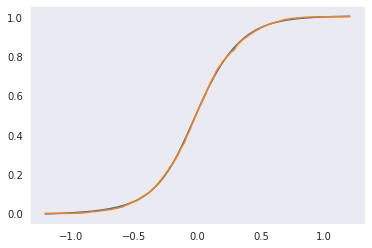

In [18]:
fitParams0 = {'verbose':2, 
             'xrange_excess': 0.2,
             'density': 1,
             'edge_density_mult':3}

mf_signal = MultiFeature(FullSignal_file, feature_names, parameters={'trainParams': trainParams, 'compileArgs':compileArgs}, xrange=(-1, 1))
mf_signal.normalise_range(4, (-1,10))


mf_signal.fitAll(fitParams0)


In [ ]:
refit_params = {'verbose':2, 
                'xrange_excess': 0.1,
                'density': 2,
                'edge_density_mult':2}

refit_train = {'epochs' : 150,
            'batch_size' : 30, 
                'verbose' : 2}

refit_array = [4]
# shady: 5, 7
mf_signal.normalise_range(4, (-1,10))
for k in refit_array:
    print(k, feature_names[k])
    # mf_signal.resetFit(4)
    mf_signal.fitFeature(k, refit_params, refit_train)
    plt.show()
    # mf_signal.drawDistComparison(k)
    # plt.show()


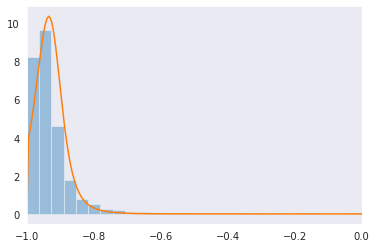

In [21]:
mf_signal.drawDistComparison(4, xrange=(-1,0), params={'bins':300})

Showing Distribuition results

0 Mother Total Momentum (GeV/c)


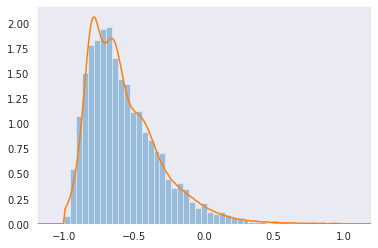

1  Mother Transverse Momentum (GeV/c)


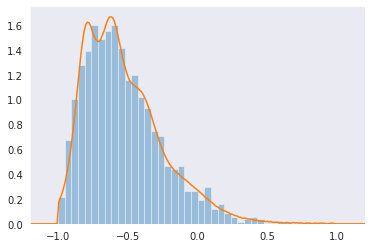

2  Mother Fraction of Transverse Momentum


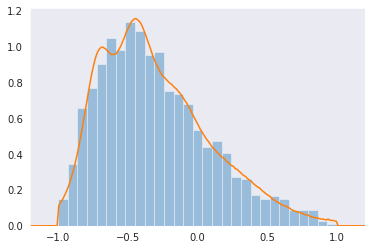

3  Opening Angle (rad)


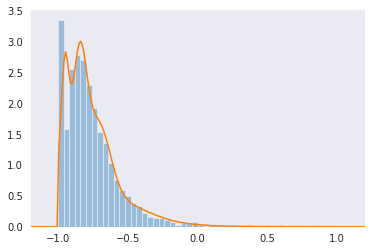

4  Impact Parameter (cm)


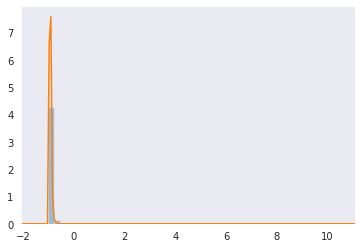

5  Daughter1 Total Momentum (GeV/c)


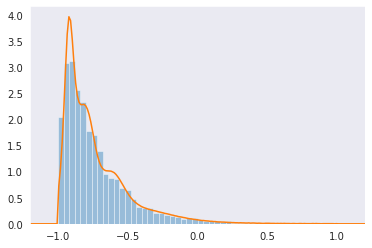

6  Daughter1 Transverse Momentum (GeV/c)


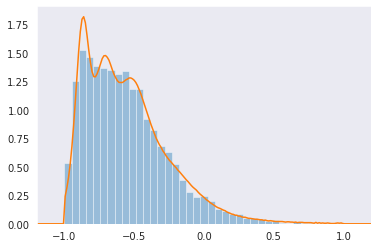

7  Daughter1 Fraction of Transverse Momentum


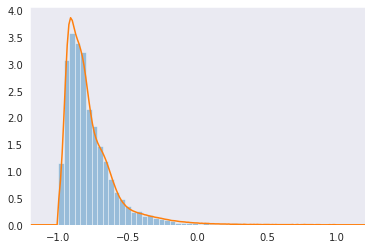

8  Daughter2 Total Momentum (GeV/c)


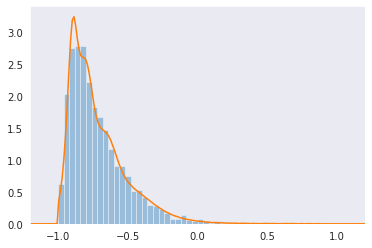

9  Daughter2 Transverse Momentum (GeV/c)


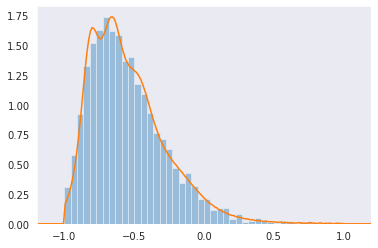

10  Daughter2 Fraction of Transverse Momentum


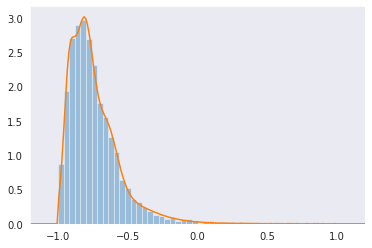

11  Decay Z (cm)


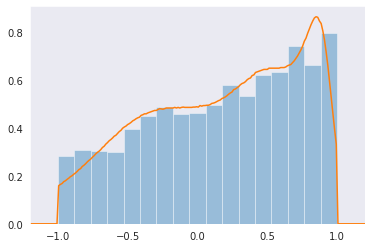

12  Decay X (cm)


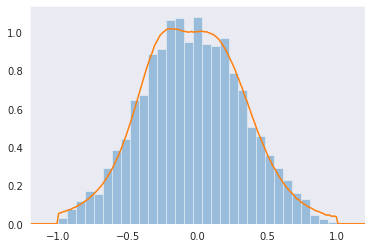

13  Decay Y (cm)


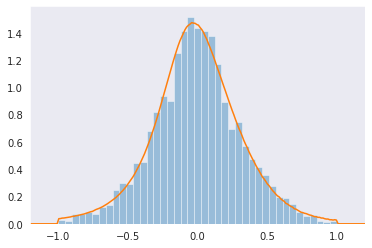

In [20]:
for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_signal.drawDistComparison(k)
    plt.show()

Saving the fitting

In [22]:
dirname = "/content/drive/My Drive/Neutralinos/Network Saves/"
filename = "{}/signal-1-{}/".format(dirname, decay_select['decay'])

mf_signal.save_distribuitions_to_file(filename)

In [ ]:
dirname = "/content/drive/My Drive/Neutralinos/Network Saves/"
filename = "{}/signal-{}/".format(dirname, decay_select['decay'])

for feat in mf_signal.features:
    tfile = "{}/feature-{}.h5".format(filename, feat.replace("/", "\\"))
    print("Saving to ", tfile)
    mf_signal.distfit_array[feat].netModel.save(tfile)
    print("\n")

mf_signal_clone = None

In [ ]:


mf_signal_clone0 = MultiFeature(FullSignal_file, feature_names, 
                                parameters={'trainParams': trainParams, 
                                            'compileArgs':compileArgs}, xrange=(-1, 1))
mf_signal_clone0.normalise_range(4, (-1,10))

mf_signal_clone0.get_distribuitions_from_file(filename)

# for feat in mf_signal.features:
#     tfile = "{}/feature-{}.h5".format(filename, feat.replace("/", "\\"))
#     print("Getting network from ", tfile)
#     mf_signal_clone.distfit_array[feat].netModel=load_model(tfile)
#     mf_signal_clone.distfit_array[feat].data = 
#     print("\n")

# mf_signal_clone.get_distribuitions_from_file("/content/drive/My Drive/Neutralinos/Network Saves/signal-K mu")

0  Finished fitting  Mother Total Momentum (GeV/c)
1  Finished fitting   Mother Transverse Momentum (GeV/c)
2  Finished fitting   Mother Fraction of Transverse Momentum
3  Finished fitting   Opening Angle (rad)
4  Finished fitting   Impact Parameter (cm)
5  Finished fitting   Daughter1 Total Momentum (GeV/c)
6  Finished fitting   Daughter1 Transverse Momentum (GeV/c)
7  Finished fitting   Daughter1 Fraction of Transverse Momentum
8  Finished fitting   Daughter2 Total Momentum (GeV/c)
9  Finished fitting   Daughter2 Transverse Momentum (GeV/c)
10  Finished fitting   Daughter2 Fraction of Transverse Momentum
11  Finished fitting   Decay Z (cm)
12  Finished fitting   Decay X (cm)
13  Finished fitting   Decay Y (cm)


In [ ]:

mf_signal_clone0.save_distribuitions_to_file("{}/testfile".format(dirname))

In [ ]:
mf_signal_clone1 = MultiFeature(FullSignal_file, feature_names, 
                                parameters={'trainParams': trainParams, 
                                            'compileArgs':compileArgs}, xrange=(-1, 1))
mf_signal_clone1.normalise_range(4, (-1,10))
mf_signal_clone1.get_distribuitions_from_file("{}/testfile".format(dirname))

0  Finished fitting  Mother Total Momentum (GeV/c)
1  Finished fitting   Mother Transverse Momentum (GeV/c)
2  Finished fitting   Mother Fraction of Transverse Momentum
3  Finished fitting   Opening Angle (rad)
4  Finished fitting   Impact Parameter (cm)
5  Finished fitting   Daughter1 Total Momentum (GeV/c)
6  Finished fitting   Daughter1 Transverse Momentum (GeV/c)
7  Finished fitting   Daughter1 Fraction of Transverse Momentum
8  Finished fitting   Daughter2 Total Momentum (GeV/c)
9  Finished fitting   Daughter2 Transverse Momentum (GeV/c)
10  Finished fitting   Daughter2 Fraction of Transverse Momentum
11  Finished fitting   Decay Z (cm)
12  Finished fitting   Decay X (cm)
13  Finished fitting   Decay Y (cm)


In [ ]:
for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_signal_clone1.drawDistComparison(k, xrange=(-1,1))
    plt.show()
    mf_signal.drawDistComparison(k, xrange=(-1,1))
    plt.show()

## Fitting the background data

In [23]:
trainParams = {'epochs' : 150,
            'batch_size' : 10, 
                'verbose' : 2}

Epoch 1/150
364/364 - 1s - loss: 0.2744
Epoch 2/150
364/364 - 1s - loss: 0.1842
Epoch 3/150
364/364 - 1s - loss: 0.1638
Epoch 4/150
364/364 - 1s - loss: 0.1194
Epoch 5/150
364/364 - 1s - loss: 0.0697
Epoch 6/150
364/364 - 1s - loss: 0.0329
Epoch 7/150
364/364 - 1s - loss: 0.0131
Epoch 8/150
364/364 - 1s - loss: 0.0048
Epoch 9/150
364/364 - 1s - loss: 0.0021
Epoch 10/150
364/364 - 1s - loss: 0.0014
Epoch 11/150
364/364 - 2s - loss: 0.0012
Epoch 12/150
364/364 - 2s - loss: 0.0011
Epoch 13/150
364/364 - 2s - loss: 9.9705e-04
Epoch 14/150
364/364 - 2s - loss: 7.6552e-04
Epoch 15/150
364/364 - 2s - loss: 4.2912e-04
Epoch 16/150
364/364 - 2s - loss: 2.5439e-04
Epoch 17/150
364/364 - 1s - loss: 2.3061e-04
Epoch 18/150
364/364 - 1s - loss: 2.2914e-04
Epoch 19/150
364/364 - 1s - loss: 2.2272e-04
Epoch 20/150
364/364 - 1s - loss: 2.2265e-04
Epoch 21/150
364/364 - 1s - loss: 2.1631e-04
Epoch 22/150
364/364 - 1s - loss: 2.1220e-04
Epoch 23/150
364/364 - 1s - loss: 2.1021e-04
Epoch 24/150
364/364 -

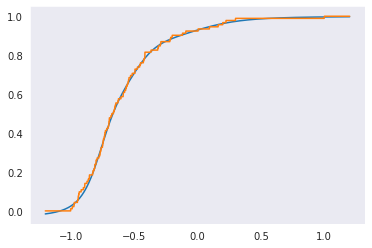

Epoch 1/150
364/364 - 1s - loss: 0.2517
Epoch 2/150
364/364 - 0s - loss: 0.1777
Epoch 3/150
364/364 - 0s - loss: 0.1524
Epoch 4/150
364/364 - 0s - loss: 0.0998
Epoch 5/150
364/364 - 0s - loss: 0.0478
Epoch 6/150
364/364 - 0s - loss: 0.0192
Epoch 7/150
364/364 - 0s - loss: 0.0078
Epoch 8/150
364/364 - 0s - loss: 0.0042
Epoch 9/150
364/364 - 1s - loss: 0.0029
Epoch 10/150
364/364 - 1s - loss: 0.0014
Epoch 11/150
364/364 - 0s - loss: 5.9107e-04
Epoch 12/150
364/364 - 0s - loss: 3.6533e-04
Epoch 13/150
364/364 - 1s - loss: 2.5617e-04
Epoch 14/150
364/364 - 1s - loss: 2.1008e-04
Epoch 15/150
364/364 - 1s - loss: 1.9067e-04
Epoch 16/150
364/364 - 0s - loss: 1.7988e-04
Epoch 17/150
364/364 - 1s - loss: 1.7367e-04
Epoch 18/150
364/364 - 1s - loss: 1.6714e-04
Epoch 19/150
364/364 - 1s - loss: 1.6185e-04
Epoch 20/150
364/364 - 1s - loss: 1.5705e-04
Epoch 21/150
364/364 - 1s - loss: 1.4880e-04
Epoch 22/150
364/364 - 1s - loss: 1.4698e-04
Epoch 23/150
364/364 - 0s - loss: 1.3840e-04
Epoch 24/150
3

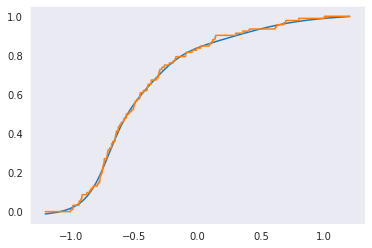

Epoch 1/150
364/364 - 1s - loss: 0.2453
Epoch 2/150
364/364 - 0s - loss: 0.1798
Epoch 3/150
364/364 - 1s - loss: 0.1610
Epoch 4/150
364/364 - 0s - loss: 0.1062
Epoch 5/150
364/364 - 0s - loss: 0.0452
Epoch 6/150
364/364 - 1s - loss: 0.0158
Epoch 7/150
364/364 - 1s - loss: 0.0067
Epoch 8/150
364/364 - 0s - loss: 0.0035
Epoch 9/150
364/364 - 0s - loss: 0.0011
Epoch 10/150
364/364 - 0s - loss: 3.2971e-04
Epoch 11/150
364/364 - 0s - loss: 1.8951e-04
Epoch 12/150
364/364 - 1s - loss: 1.6291e-04
Epoch 13/150
364/364 - 0s - loss: 1.5620e-04
Epoch 14/150
364/364 - 0s - loss: 1.5021e-04
Epoch 15/150
364/364 - 0s - loss: 1.4361e-04
Epoch 16/150
364/364 - 0s - loss: 1.3843e-04
Epoch 17/150
364/364 - 0s - loss: 1.3172e-04
Epoch 18/150
364/364 - 0s - loss: 1.2508e-04
Epoch 19/150
364/364 - 0s - loss: 1.2033e-04
Epoch 20/150
364/364 - 0s - loss: 1.1611e-04
Epoch 21/150
364/364 - 0s - loss: 1.1133e-04
Epoch 22/150
364/364 - 0s - loss: 1.0580e-04
Epoch 23/150
364/364 - 1s - loss: 1.0296e-04
Epoch 24/1

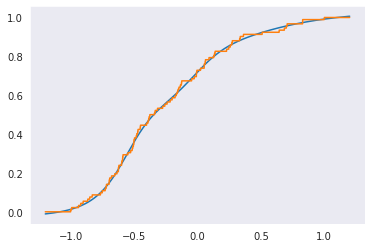

Epoch 1/150
364/364 - 0s - loss: 0.2317
Epoch 2/150
364/364 - 0s - loss: 0.1798
Epoch 3/150
364/364 - 1s - loss: 0.1625
Epoch 4/150
364/364 - 1s - loss: 0.1214
Epoch 5/150
364/364 - 0s - loss: 0.0614
Epoch 6/150
364/364 - 0s - loss: 0.0228
Epoch 7/150
364/364 - 0s - loss: 0.0083
Epoch 8/150
364/364 - 0s - loss: 0.0043
Epoch 9/150
364/364 - 0s - loss: 0.0031
Epoch 10/150
364/364 - 0s - loss: 0.0024
Epoch 11/150
364/364 - 0s - loss: 0.0013
Epoch 12/150
364/364 - 0s - loss: 5.8236e-04
Epoch 13/150
364/364 - 0s - loss: 3.6455e-04
Epoch 14/150
364/364 - 0s - loss: 2.7597e-04
Epoch 15/150
364/364 - 0s - loss: 2.5374e-04
Epoch 16/150
364/364 - 1s - loss: 2.4531e-04
Epoch 17/150
364/364 - 1s - loss: 2.4075e-04
Epoch 18/150
364/364 - 0s - loss: 2.3985e-04
Epoch 19/150
364/364 - 0s - loss: 2.3608e-04
Epoch 20/150
364/364 - 0s - loss: 2.3218e-04
Epoch 21/150
364/364 - 1s - loss: 2.2563e-04
Epoch 22/150
364/364 - 0s - loss: 2.2397e-04
Epoch 23/150
364/364 - 1s - loss: 2.1788e-04
Epoch 24/150
364/3

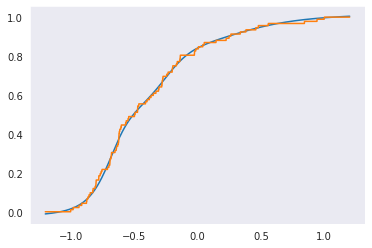

Epoch 1/150
364/364 - 1s - loss: 0.2659
Epoch 2/150
364/364 - 0s - loss: 0.1694
Epoch 3/150
364/364 - 0s - loss: 0.1141
Epoch 4/150
364/364 - 1s - loss: 0.0535
Epoch 5/150
364/364 - 0s - loss: 0.0209
Epoch 6/150
364/364 - 1s - loss: 0.0077
Epoch 7/150
364/364 - 0s - loss: 0.0037
Epoch 8/150
364/364 - 0s - loss: 0.0018
Epoch 9/150
364/364 - 0s - loss: 5.1863e-04
Epoch 10/150
364/364 - 1s - loss: 1.6483e-04
Epoch 11/150
364/364 - 0s - loss: 8.5652e-05
Epoch 12/150
364/364 - 0s - loss: 7.0611e-05
Epoch 13/150
364/364 - 0s - loss: 6.7912e-05
Epoch 14/150
364/364 - 1s - loss: 6.6930e-05
Epoch 15/150
364/364 - 1s - loss: 6.6403e-05
Epoch 16/150
364/364 - 0s - loss: 6.5049e-05
Epoch 17/150
364/364 - 0s - loss: 6.5959e-05
Epoch 18/150
364/364 - 1s - loss: 6.6580e-05
Epoch 19/150
364/364 - 1s - loss: 6.3993e-05
Epoch 20/150
364/364 - 0s - loss: 6.7557e-05
Epoch 21/150
364/364 - 0s - loss: 6.7330e-05
Epoch 22/150
364/364 - 0s - loss: 6.5611e-05
4  Finished fitting   Impact Parameter (cm)


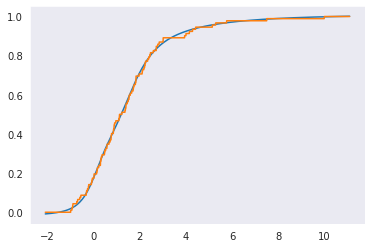

Epoch 1/150
364/364 - 1s - loss: 0.2066
Epoch 2/150
364/364 - 0s - loss: 0.1747
Epoch 3/150
364/364 - 0s - loss: 0.1556
Epoch 4/150
364/364 - 0s - loss: 0.1086
Epoch 5/150
364/364 - 0s - loss: 0.0583
Epoch 6/150
364/364 - 0s - loss: 0.0276
Epoch 7/150
364/364 - 0s - loss: 0.0126
Epoch 8/150
364/364 - 0s - loss: 0.0064
Epoch 9/150
364/364 - 0s - loss: 0.0041
Epoch 10/150
364/364 - 1s - loss: 0.0033
Epoch 11/150
364/364 - 0s - loss: 0.0027
Epoch 12/150
364/364 - 0s - loss: 0.0018
Epoch 13/150
364/364 - 0s - loss: 0.0010
Epoch 14/150
364/364 - 0s - loss: 8.6433e-04
Epoch 15/150
364/364 - 0s - loss: 8.0269e-04
Epoch 16/150
364/364 - 0s - loss: 7.7344e-04
Epoch 17/150
364/364 - 0s - loss: 7.4971e-04
Epoch 18/150
364/364 - 1s - loss: 7.3214e-04
Epoch 19/150
364/364 - 1s - loss: 7.1865e-04
Epoch 20/150
364/364 - 1s - loss: 7.1537e-04
Epoch 21/150
364/364 - 1s - loss: 7.0673e-04
Epoch 22/150
364/364 - 1s - loss: 6.9545e-04
Epoch 23/150
364/364 - 1s - loss: 6.8820e-04
Epoch 24/150
364/364 - 0s 

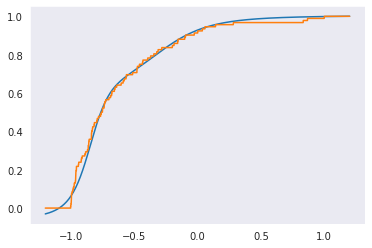

Epoch 1/150
364/364 - 1s - loss: 0.2286
Epoch 2/150
364/364 - 1s - loss: 0.1719
Epoch 3/150
364/364 - 0s - loss: 0.1543
Epoch 4/150
364/364 - 0s - loss: 0.1076
Epoch 5/150
364/364 - 0s - loss: 0.0584
Epoch 6/150
364/364 - 0s - loss: 0.0285
Epoch 7/150
364/364 - 0s - loss: 0.0137
Epoch 8/150
364/364 - 0s - loss: 0.0076
Epoch 9/150
364/364 - 0s - loss: 0.0052
Epoch 10/150
364/364 - 0s - loss: 0.0041
Epoch 11/150
364/364 - 0s - loss: 0.0023
Epoch 12/150
364/364 - 0s - loss: 0.0011
Epoch 13/150
364/364 - 0s - loss: 8.1126e-04
Epoch 14/150
364/364 - 0s - loss: 6.5307e-04
Epoch 15/150
364/364 - 0s - loss: 5.8041e-04
Epoch 16/150
364/364 - 0s - loss: 5.4127e-04
Epoch 17/150
364/364 - 0s - loss: 5.1168e-04
Epoch 18/150
364/364 - 0s - loss: 4.8838e-04
Epoch 19/150
364/364 - 0s - loss: 4.6885e-04
Epoch 20/150
364/364 - 0s - loss: 4.5457e-04
Epoch 21/150
364/364 - 0s - loss: 4.3719e-04
Epoch 22/150
364/364 - 0s - loss: 4.2744e-04
Epoch 23/150
364/364 - 0s - loss: 4.1629e-04
Epoch 24/150
364/364 -

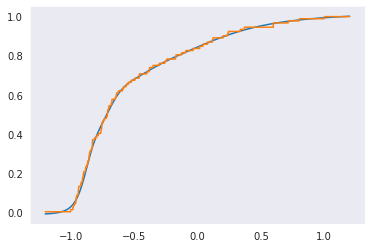

Epoch 1/150
364/364 - 1s - loss: 0.2596
Epoch 2/150
364/364 - 0s - loss: 0.1865
Epoch 3/150
364/364 - 1s - loss: 0.1609
Epoch 4/150
364/364 - 0s - loss: 0.1013
Epoch 5/150
364/364 - 0s - loss: 0.0468
Epoch 6/150
364/364 - 0s - loss: 0.0165
Epoch 7/150
364/364 - 0s - loss: 0.0052
Epoch 8/150
364/364 - 0s - loss: 0.0021
Epoch 9/150
364/364 - 0s - loss: 0.0014
Epoch 10/150
364/364 - 0s - loss: 0.0010
Epoch 11/150
364/364 - 0s - loss: 6.1355e-04
Epoch 12/150
364/364 - 0s - loss: 3.5511e-04
Epoch 13/150
364/364 - 0s - loss: 2.4035e-04
Epoch 14/150
364/364 - 0s - loss: 2.0951e-04
Epoch 15/150
364/364 - 0s - loss: 2.0116e-04
Epoch 16/150
364/364 - 0s - loss: 1.9573e-04
Epoch 17/150
364/364 - 0s - loss: 1.9272e-04
Epoch 18/150
364/364 - 0s - loss: 1.8915e-04
Epoch 19/150
364/364 - 0s - loss: 1.8723e-04
Epoch 20/150
364/364 - 0s - loss: 1.8050e-04
Epoch 21/150
364/364 - 0s - loss: 1.7609e-04
Epoch 22/150
364/364 - 0s - loss: 1.6539e-04
Epoch 23/150
364/364 - 0s - loss: 1.5574e-04
Epoch 24/150
3

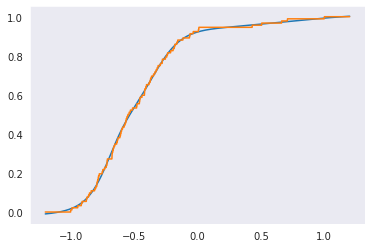

Epoch 1/150
364/364 - 1s - loss: 0.2504
Epoch 2/150
364/364 - 1s - loss: 0.1770
Epoch 3/150
364/364 - 1s - loss: 0.1606
Epoch 4/150
364/364 - 1s - loss: 0.1182
Epoch 5/150
364/364 - 0s - loss: 0.0691
Epoch 6/150
364/364 - 0s - loss: 0.0356
Epoch 7/150
364/364 - 0s - loss: 0.0170
Epoch 8/150
364/364 - 0s - loss: 0.0084
Epoch 9/150
364/364 - 0s - loss: 0.0049
Epoch 10/150
364/364 - 1s - loss: 0.0035
Epoch 11/150
364/364 - 0s - loss: 0.0029
Epoch 12/150
364/364 - 0s - loss: 0.0023
Epoch 13/150
364/364 - 0s - loss: 0.0015
Epoch 14/150
364/364 - 0s - loss: 0.0011
Epoch 15/150
364/364 - 0s - loss: 0.0010
Epoch 16/150
364/364 - 0s - loss: 0.0010
Epoch 17/150
364/364 - 0s - loss: 9.8109e-04
Epoch 18/150
364/364 - 0s - loss: 9.5910e-04
Epoch 19/150
364/364 - 0s - loss: 9.4868e-04
Epoch 20/150
364/364 - 0s - loss: 9.2958e-04
Epoch 21/150
364/364 - 0s - loss: 9.3468e-04
Epoch 22/150
364/364 - 0s - loss: 9.1230e-04
Epoch 23/150
364/364 - 1s - loss: 9.0241e-04
Epoch 24/150
364/364 - 1s - loss: 8.84

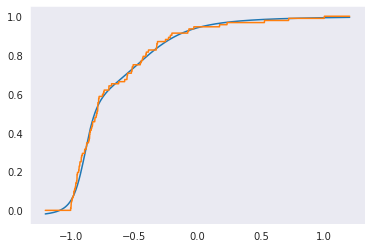

Epoch 1/150
364/364 - 1s - loss: 0.2539
Epoch 2/150
364/364 - 0s - loss: 0.1804
Epoch 3/150
364/364 - 0s - loss: 0.1638
Epoch 4/150
364/364 - 0s - loss: 0.1188
Epoch 5/150
364/364 - 0s - loss: 0.0685
Epoch 6/150
364/364 - 0s - loss: 0.0339
Epoch 7/150
364/364 - 0s - loss: 0.0148
Epoch 8/150
364/364 - 0s - loss: 0.0062
Epoch 9/150
364/364 - 0s - loss: 0.0031
Epoch 10/150
364/364 - 0s - loss: 0.0021
Epoch 11/150
364/364 - 0s - loss: 0.0018
Epoch 12/150
364/364 - 0s - loss: 0.0016
Epoch 13/150
364/364 - 0s - loss: 0.0014
Epoch 14/150
364/364 - 0s - loss: 9.5822e-04
Epoch 15/150
364/364 - 0s - loss: 5.9622e-04
Epoch 16/150
364/364 - 0s - loss: 5.2418e-04
Epoch 17/150
364/364 - 0s - loss: 5.1530e-04
Epoch 18/150
364/364 - 0s - loss: 5.1050e-04
Epoch 19/150
364/364 - 1s - loss: 5.0419e-04
Epoch 20/150
364/364 - 0s - loss: 4.9907e-04
Epoch 21/150
364/364 - 0s - loss: 4.9608e-04
Epoch 22/150
364/364 - 0s - loss: 4.9484e-04
Epoch 23/150
364/364 - 0s - loss: 4.9132e-04
Epoch 24/150
364/364 - 0s 

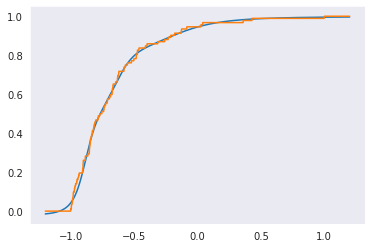

Epoch 1/150
364/364 - 1s - loss: 0.2806
Epoch 2/150
364/364 - 0s - loss: 0.1814
Epoch 3/150
364/364 - 0s - loss: 0.1612
Epoch 4/150
364/364 - 0s - loss: 0.1089
Epoch 5/150
364/364 - 0s - loss: 0.0405
Epoch 6/150
364/364 - 0s - loss: 0.0083
Epoch 7/150
364/364 - 0s - loss: 0.0026
Epoch 8/150
364/364 - 0s - loss: 0.0019
Epoch 9/150
364/364 - 0s - loss: 0.0014
Epoch 10/150
364/364 - 0s - loss: 7.7744e-04
Epoch 11/150
364/364 - 0s - loss: 4.1903e-04
Epoch 12/150
364/364 - 0s - loss: 3.5336e-04
Epoch 13/150
364/364 - 0s - loss: 3.3447e-04
Epoch 14/150
364/364 - 0s - loss: 3.2874e-04
Epoch 15/150
364/364 - 0s - loss: 3.2202e-04
Epoch 16/150
364/364 - 0s - loss: 3.1771e-04
Epoch 17/150
364/364 - 0s - loss: 3.1728e-04
Epoch 18/150
364/364 - 0s - loss: 3.1883e-04
Epoch 19/150
364/364 - 0s - loss: 3.1248e-04
Epoch 20/150
364/364 - 0s - loss: 3.1350e-04
Epoch 21/150
364/364 - 0s - loss: 3.1152e-04
Epoch 22/150
364/364 - 0s - loss: 3.1241e-04
Epoch 23/150
364/364 - 0s - loss: 3.0605e-04
Epoch 24/1

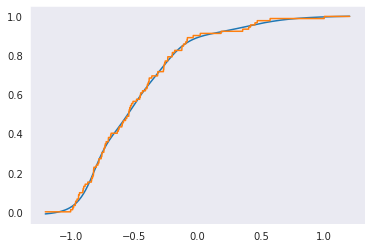

Epoch 1/150
364/364 - 0s - loss: 0.2296
Epoch 2/150
364/364 - 0s - loss: 0.1635
Epoch 3/150
364/364 - 0s - loss: 0.1492
Epoch 4/150
364/364 - 0s - loss: 0.1206
Epoch 5/150
364/364 - 0s - loss: 0.0713
Epoch 6/150
364/364 - 0s - loss: 0.0325
Epoch 7/150
364/364 - 0s - loss: 0.0156
Epoch 8/150
364/364 - 0s - loss: 0.0093
Epoch 9/150
364/364 - 0s - loss: 0.0069
Epoch 10/150
364/364 - 0s - loss: 0.0052
Epoch 11/150
364/364 - 0s - loss: 0.0030
Epoch 12/150
364/364 - 0s - loss: 0.0020
Epoch 13/150
364/364 - 0s - loss: 0.0015
Epoch 14/150
364/364 - 0s - loss: 0.0010
Epoch 15/150
364/364 - 0s - loss: 8.0905e-04
Epoch 16/150
364/364 - 0s - loss: 7.0394e-04
Epoch 17/150
364/364 - 0s - loss: 6.5510e-04
Epoch 18/150
364/364 - 0s - loss: 6.2233e-04
Epoch 19/150
364/364 - 0s - loss: 6.0913e-04
Epoch 20/150
364/364 - 0s - loss: 5.8700e-04
Epoch 21/150
364/364 - 1s - loss: 5.8147e-04
Epoch 22/150
364/364 - 0s - loss: 5.6839e-04
Epoch 23/150
364/364 - 0s - loss: 5.6680e-04
Epoch 24/150
364/364 - 0s - lo

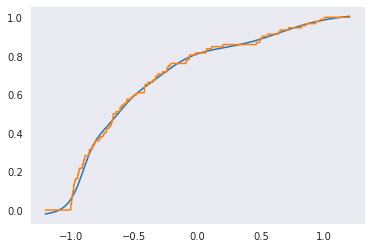

Epoch 1/150
364/364 - 1s - loss: 0.2456
Epoch 2/150
364/364 - 0s - loss: 0.2054
Epoch 3/150
364/364 - 1s - loss: 0.1837
Epoch 4/150
364/364 - 0s - loss: 0.0961
Epoch 5/150
364/364 - 0s - loss: 0.0114
Epoch 6/150
364/364 - 0s - loss: 5.1520e-04
Epoch 7/150
364/364 - 0s - loss: 2.6712e-04
Epoch 8/150
364/364 - 0s - loss: 2.4573e-04
Epoch 9/150
364/364 - 0s - loss: 2.2905e-04
Epoch 10/150
364/364 - 0s - loss: 2.1297e-04
Epoch 11/150
364/364 - 0s - loss: 2.0310e-04
Epoch 12/150
364/364 - 0s - loss: 1.9497e-04
Epoch 13/150
364/364 - 0s - loss: 1.8998e-04
Epoch 14/150
364/364 - 0s - loss: 1.8370e-04
Epoch 15/150
364/364 - 0s - loss: 1.7955e-04
Epoch 16/150
364/364 - 0s - loss: 1.7571e-04
Epoch 17/150
364/364 - 0s - loss: 1.6803e-04
Epoch 18/150
364/364 - 0s - loss: 1.5539e-04
Epoch 19/150
364/364 - 0s - loss: 1.4539e-04
Epoch 20/150
364/364 - 0s - loss: 1.3455e-04
Epoch 21/150
364/364 - 0s - loss: 1.2429e-04
Epoch 22/150
364/364 - 0s - loss: 1.1976e-04
Epoch 23/150
364/364 - 0s - loss: 1.112

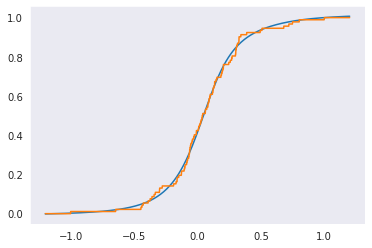

Epoch 1/150
364/364 - 1s - loss: 0.2297
Epoch 2/150
364/364 - 1s - loss: 0.2067
Epoch 3/150
364/364 - 0s - loss: 0.1915
Epoch 4/150
364/364 - 1s - loss: 0.1432
Epoch 5/150
364/364 - 0s - loss: 0.0565
Epoch 6/150
364/364 - 0s - loss: 0.0111
Epoch 7/150
364/364 - 0s - loss: 0.0013
Epoch 8/150
364/364 - 0s - loss: 3.0641e-04
Epoch 9/150
364/364 - 0s - loss: 2.5450e-04
Epoch 10/150
364/364 - 0s - loss: 2.5215e-04
Epoch 11/150
364/364 - 0s - loss: 2.5062e-04
Epoch 12/150
364/364 - 0s - loss: 2.5125e-04
Epoch 13/150
364/364 - 0s - loss: 2.5135e-04
Epoch 14/150
364/364 - 0s - loss: 2.4945e-04
Epoch 15/150
364/364 - 0s - loss: 2.5283e-04
Epoch 16/150
364/364 - 0s - loss: 2.5137e-04
Epoch 17/150
364/364 - 0s - loss: 2.5041e-04
13  Finished fitting   Decay Y (cm)


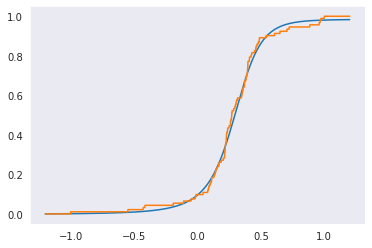

In [24]:
fitParams1 = {'verbose':2, 
             'xrange_excess': 0.2,
             'density': 3,
             'edge_density_mult':3}

mf_background = MultiFeature(FullBackground_file, feature_names, parameters={'trainParams': trainParams, 'compileArgs':compileArgs}, xrange = (-1,1))
mf_background.normalise_range(4, (-1,10))


# mf_background.get_distribuitions_from_file(filename_signal)
mf_background.fitAll(fitParams1)

Attempting refits on the worse fits

2  Mother Fraction of Transverse Momentum
Epoch 1/150
58/58 - 0s - loss: 0.4133
Epoch 2/150
58/58 - 0s - loss: 0.2649
Epoch 3/150
58/58 - 0s - loss: 0.2075
Epoch 4/150
58/58 - 0s - loss: 0.1972
Epoch 5/150
58/58 - 0s - loss: 0.1955
Epoch 6/150
58/58 - 0s - loss: 0.1942
Epoch 7/150
58/58 - 0s - loss: 0.1927
Epoch 8/150
58/58 - 0s - loss: 0.1909
Epoch 9/150
58/58 - 0s - loss: 0.1885
Epoch 10/150
58/58 - 0s - loss: 0.1851
Epoch 11/150
58/58 - 0s - loss: 0.1803
Epoch 12/150
58/58 - 0s - loss: 0.1732
Epoch 13/150
58/58 - 0s - loss: 0.1630
Epoch 14/150
58/58 - 0s - loss: 0.1487
Epoch 15/150
58/58 - 0s - loss: 0.1305
Epoch 16/150
58/58 - 0s - loss: 0.1090
Epoch 17/150
58/58 - 0s - loss: 0.0865
Epoch 18/150
58/58 - 0s - loss: 0.0650
Epoch 19/150
58/58 - 0s - loss: 0.0465
Epoch 20/150
58/58 - 0s - loss: 0.0318
Epoch 21/150
58/58 - 0s - loss: 0.0209
Epoch 22/150
58/58 - 0s - loss: 0.0135
Epoch 23/150
58/58 - 0s - loss: 0.0088
Epoch 24/150
58/58 - 0s - loss: 0.0059
Epoch 25/150
58/58 - 0s - loss:

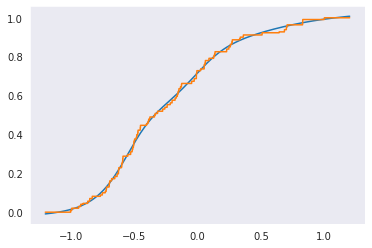

4  Impact Parameter (cm)
Epoch 1/150
58/58 - 0s - loss: 0.4011
Epoch 2/150
58/58 - 0s - loss: 0.2623
Epoch 3/150
58/58 - 0s - loss: 0.2090
Epoch 4/150
58/58 - 0s - loss: 0.1991
Epoch 5/150
58/58 - 0s - loss: 0.1958
Epoch 6/150
58/58 - 0s - loss: 0.1926
Epoch 7/150
58/58 - 0s - loss: 0.1887
Epoch 8/150
58/58 - 0s - loss: 0.1836
Epoch 9/150
58/58 - 0s - loss: 0.1763
Epoch 10/150
58/58 - 0s - loss: 0.1655
Epoch 11/150
58/58 - 0s - loss: 0.1501
Epoch 12/150
58/58 - 0s - loss: 0.1297
Epoch 13/150
58/58 - 0s - loss: 0.1083
Epoch 14/150
58/58 - 0s - loss: 0.0896
Epoch 15/150
58/58 - 0s - loss: 0.0737
Epoch 16/150
58/58 - 0s - loss: 0.0601
Epoch 17/150
58/58 - 0s - loss: 0.0485
Epoch 18/150
58/58 - 0s - loss: 0.0388
Epoch 19/150
58/58 - 0s - loss: 0.0307
Epoch 20/150
58/58 - 0s - loss: 0.0241
Epoch 21/150
58/58 - 0s - loss: 0.0189
Epoch 22/150
58/58 - 0s - loss: 0.0147
Epoch 23/150
58/58 - 0s - loss: 0.0115
Epoch 24/150
58/58 - 0s - loss: 0.0091
Epoch 25/150
58/58 - 0s - loss: 0.0072
Epoch 26/

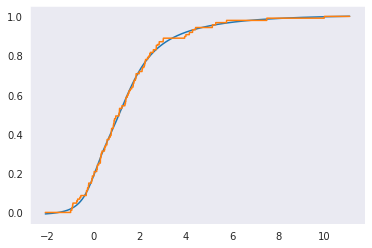

5  Daughter1 Total Momentum (GeV/c)
Epoch 1/150
58/58 - 0s - loss: 0.5501
Epoch 2/150
58/58 - 0s - loss: 0.3625
Epoch 3/150
58/58 - 0s - loss: 0.2482
Epoch 4/150
58/58 - 0s - loss: 0.2025
Epoch 5/150
58/58 - 0s - loss: 0.1939
Epoch 6/150
58/58 - 0s - loss: 0.1918
Epoch 7/150
58/58 - 0s - loss: 0.1899
Epoch 8/150
58/58 - 0s - loss: 0.1878
Epoch 9/150
58/58 - 0s - loss: 0.1854
Epoch 10/150
58/58 - 0s - loss: 0.1823
Epoch 11/150
58/58 - 0s - loss: 0.1784
Epoch 12/150
58/58 - 0s - loss: 0.1731
Epoch 13/150
58/58 - 0s - loss: 0.1658
Epoch 14/150
58/58 - 0s - loss: 0.1557
Epoch 15/150
58/58 - 0s - loss: 0.1434
Epoch 16/150
58/58 - 0s - loss: 0.1296
Epoch 17/150
58/58 - 0s - loss: 0.1157
Epoch 18/150
58/58 - 0s - loss: 0.1022
Epoch 19/150
58/58 - 0s - loss: 0.0896
Epoch 20/150
58/58 - 0s - loss: 0.0779
Epoch 21/150
58/58 - 0s - loss: 0.0673
Epoch 22/150
58/58 - 0s - loss: 0.0577
Epoch 23/150
58/58 - 0s - loss: 0.0492
Epoch 24/150
58/58 - 0s - loss: 0.0416
Epoch 25/150
58/58 - 0s - loss: 0.035

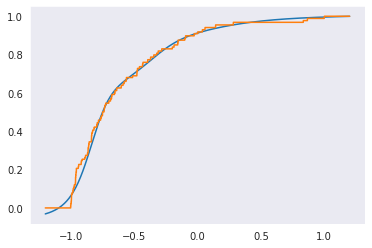

10  Daughter2 Fraction of Transverse Momentum
Epoch 1/150
58/58 - 0s - loss: 0.5854
Epoch 2/150
58/58 - 0s - loss: 0.3933
Epoch 3/150
58/58 - 0s - loss: 0.2736
Epoch 4/150
58/58 - 0s - loss: 0.2149
Epoch 5/150
58/58 - 0s - loss: 0.1990
Epoch 6/150
58/58 - 0s - loss: 0.1958
Epoch 7/150
58/58 - 0s - loss: 0.1938
Epoch 8/150
58/58 - 0s - loss: 0.1918
Epoch 9/150
58/58 - 0s - loss: 0.1893
Epoch 10/150
58/58 - 0s - loss: 0.1864
Epoch 11/150
58/58 - 0s - loss: 0.1828
Epoch 12/150
58/58 - 0s - loss: 0.1783
Epoch 13/150
58/58 - 0s - loss: 0.1722
Epoch 14/150
58/58 - 0s - loss: 0.1637
Epoch 15/150
58/58 - 0s - loss: 0.1525
Epoch 16/150
58/58 - 0s - loss: 0.1389
Epoch 17/150
58/58 - 0s - loss: 0.1240
Epoch 18/150
58/58 - 0s - loss: 0.1093
Epoch 19/150
58/58 - 0s - loss: 0.0951
Epoch 20/150
58/58 - 0s - loss: 0.0820
Epoch 21/150
58/58 - 0s - loss: 0.0701
Epoch 22/150
58/58 - 0s - loss: 0.0594
Epoch 23/150
58/58 - 0s - loss: 0.0499
Epoch 24/150
58/58 - 0s - loss: 0.0416
Epoch 25/150
58/58 - 0s - l

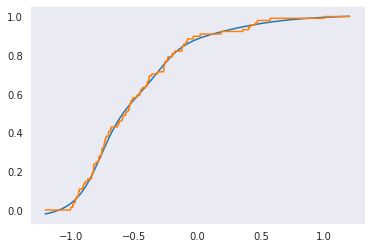

In [ ]:
refit_params = {'verbose':2, 
                'xrange_excess': 0.2,
                'density': 5,
                'edge_density_mult':4}

refit_train = {'epochs' : 150,
            'batch_size' : 100, 
                'verbose' : 2}

refit_array = [2,4,5,10]
# 2, 4, 5, 10
for k in refit_array:
    print(k, feature_names[k])
    mf_background.resetFit(k)
    mf_background.fitFeature(k, refit_params, refit_train)
    plt.show()
    # mf_signal.drawDistComparison(k)
    # plt.show()


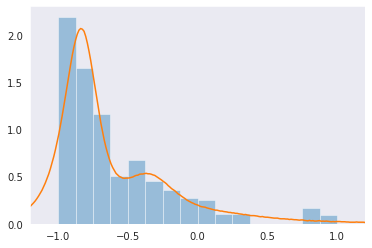

In [ ]:
mf_background.drawDistComparison(5)


0 Mother Total Momentum (GeV/c)


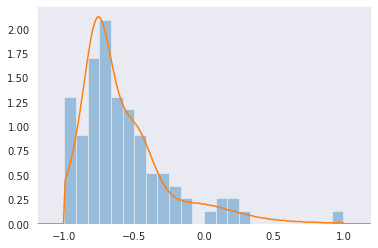

1  Mother Transverse Momentum (GeV/c)


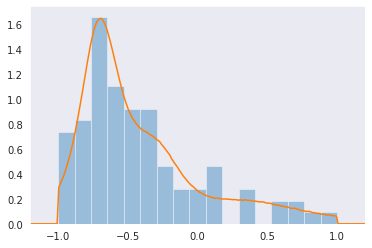

2  Mother Fraction of Transverse Momentum


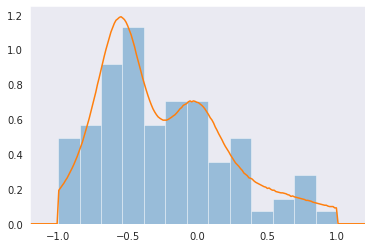

3  Opening Angle (rad)


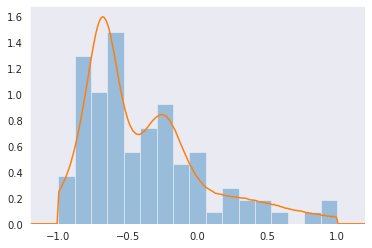

4  Impact Parameter (cm)


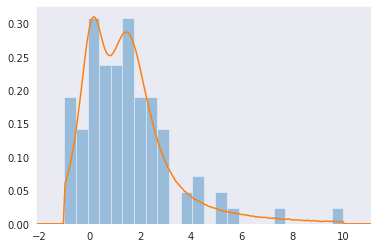

5  Daughter1 Total Momentum (GeV/c)


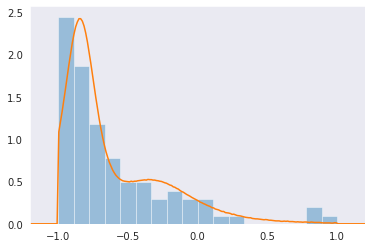

6  Daughter1 Transverse Momentum (GeV/c)


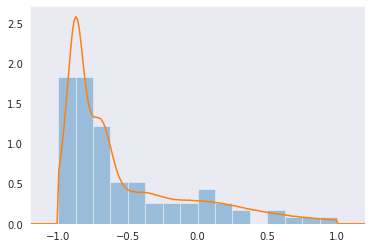

7  Daughter1 Fraction of Transverse Momentum


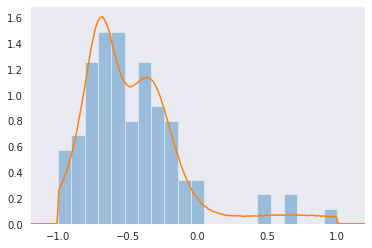

8  Daughter2 Total Momentum (GeV/c)


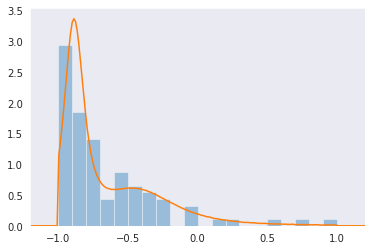

9  Daughter2 Transverse Momentum (GeV/c)


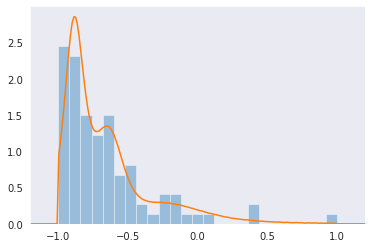

10  Daughter2 Fraction of Transverse Momentum


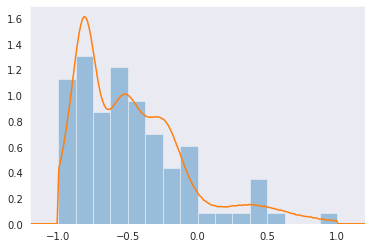

11  Decay Z (cm)


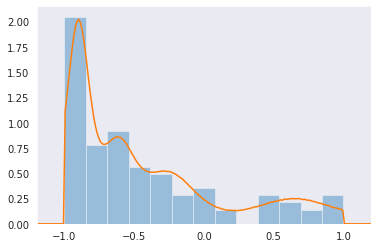

12  Decay X (cm)


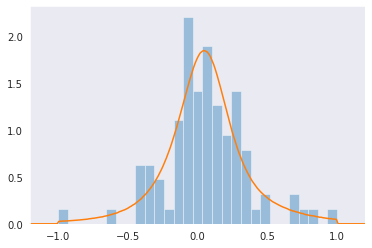

13  Decay Y (cm)


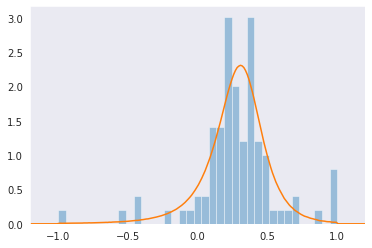

In [25]:
for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_background.drawDistComparison(k)
    plt.show()

In [27]:
# filename = "/content/drive/My Drive/Neutralinos/Network Saves/background-{}".format(decay_select['decay'])
dirname = "/content/drive/My Drive/Neutralinos/Network Saves/"
filename = "{}/background-1-{}/".format(dirname, decay_select['decay'])

mf_background.save_distribuitions_to_file(filename)

# Analysis of probability results on validation data

Needs to run "Choosing file and Loading data arrays"

In [27]:
# decay = [susy=1] ('pi pi', 'pi mu') [susy=2] ('K mu', 'mu mu')
decay_analysis = 'K mu'

dirname = "Network Saves\\"
filename_signal = "{}\\signal-1-{}\\".format(dirname, decay_analysis)
filename_background = "{}\\background-1-{}\\".format(dirname, decay_analysis)

selected_features = [0,1,2,3,5,6,7,8,9,10,11,12,13,14]
feature_names = [all_features[i] for i in selected_features]

# load the distribuitions from memory
mf_signal = MultiFeature(FullSignal_file, feature_names, parameters={'trainParams': trainParams, 'compileArgs':compileArgs}, xrange=(-1, 1))
mf_signal.normalise_range(4, (-1,10))
mf_signal.get_distribuitions_from_file(filename_signal)

mf_background = MultiFeature(FullBackground_file, feature_names, parameters={'trainParams': trainParams, 'compileArgs':compileArgs}, xrange=(-1, 1))
mf_background.normalise_range(4, (-1,10))
mf_background.get_distribuitions_from_file(filename_background)


0  Finished fitting  Mother Total Momentum (GeV/c)
1  Finished fitting   Mother Transverse Momentum (GeV/c)
2  Finished fitting   Mother Fraction of Transverse Momentum
3  Finished fitting   Opening Angle (rad)
4  Finished fitting   Impact Parameter (cm)
5  Finished fitting   Daughter1 Total Momentum (GeV/c)
6  Finished fitting   Daughter1 Transverse Momentum (GeV/c)
7  Finished fitting   Daughter1 Fraction of Transverse Momentum
8  Finished fitting   Daughter2 Total Momentum (GeV/c)
9  Finished fitting   Daughter2 Transverse Momentum (GeV/c)
10  Finished fitting   Daughter2 Fraction of Transverse Momentum
11  Finished fitting   Decay Z (cm)
12  Finished fitting   Decay X (cm)
13  Finished fitting   Decay Y (cm)
0  Finished fitting  Mother Total Momentum (GeV/c)
1  Finished fitting   Mother Transverse Momentum (GeV/c)
2  Finished fitting   Mother Fraction of Transverse Momentum
3  Finished fitting   Opening Angle (rad)
4  Finished fitting   Impact Parameter (cm)
5  Finished fitting   D

In [16]:
os.path.isdir("Network Saves")

True

0 Mother Total Momentum (GeV/c)


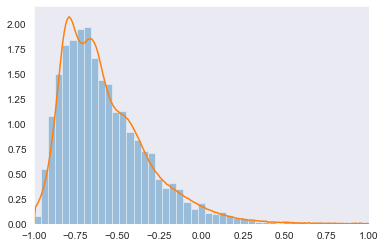

1  Mother Transverse Momentum (GeV/c)


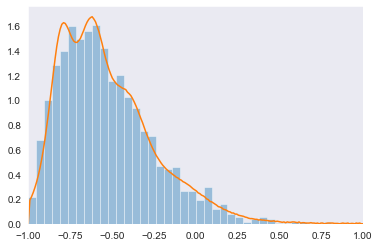

2  Mother Fraction of Transverse Momentum


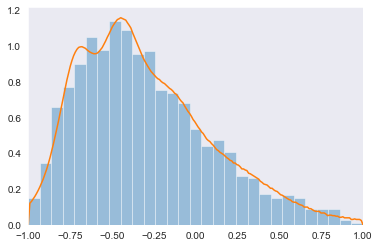

3  Opening Angle (rad)


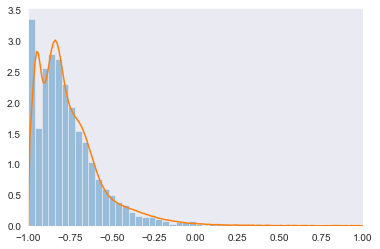

4  Impact Parameter (cm)


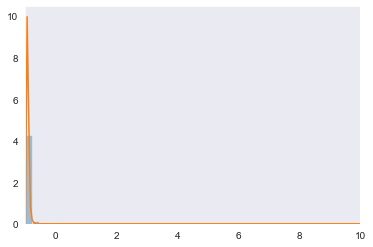

5  Daughter1 Total Momentum (GeV/c)


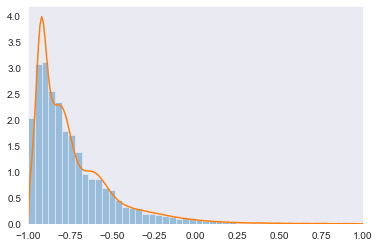

6  Daughter1 Transverse Momentum (GeV/c)


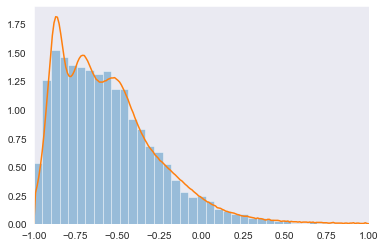

7  Daughter1 Fraction of Transverse Momentum


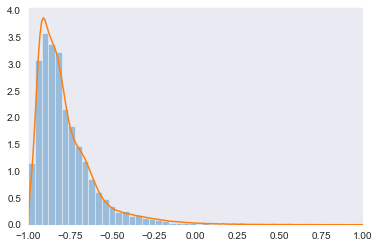

8  Daughter2 Total Momentum (GeV/c)


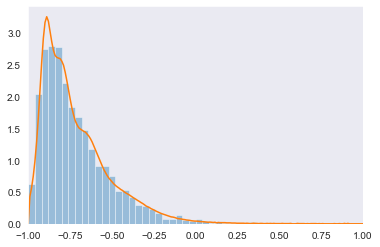

9  Daughter2 Transverse Momentum (GeV/c)


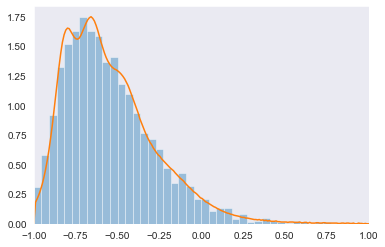

10  Daughter2 Fraction of Transverse Momentum


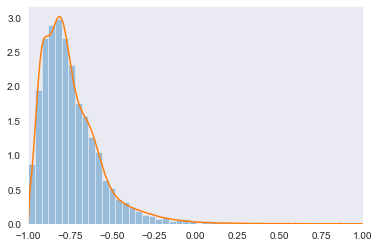

11  Decay Z (cm)


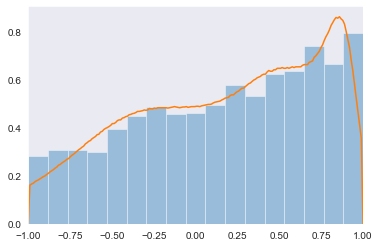

12  Decay X (cm)


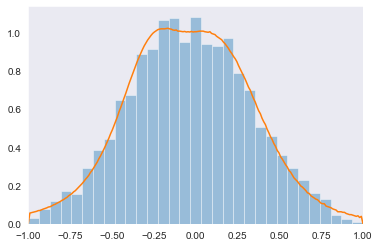

13  Decay Y (cm)


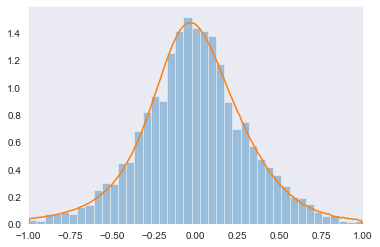

0 Mother Total Momentum (GeV/c)


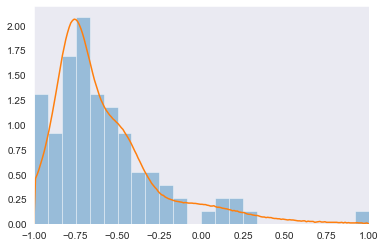

1  Mother Transverse Momentum (GeV/c)


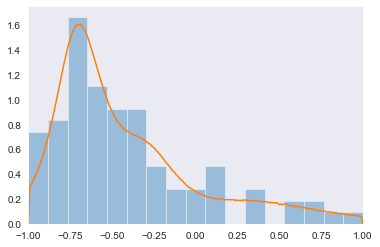

2  Mother Fraction of Transverse Momentum


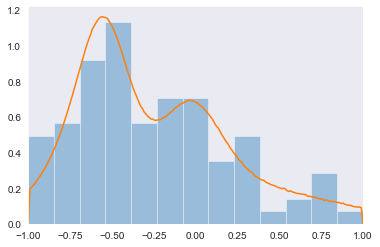

3  Opening Angle (rad)


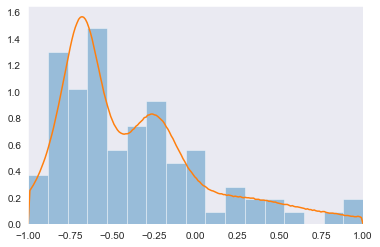

4  Impact Parameter (cm)


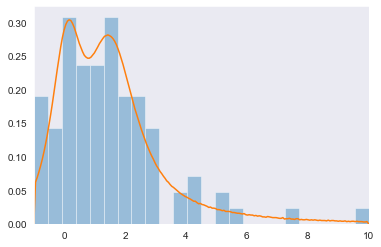

5  Daughter1 Total Momentum (GeV/c)


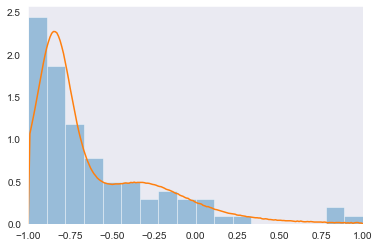

6  Daughter1 Transverse Momentum (GeV/c)


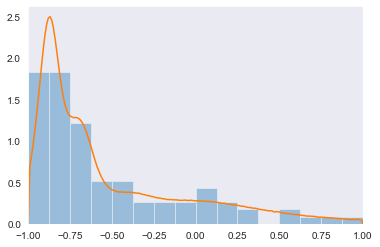

7  Daughter1 Fraction of Transverse Momentum


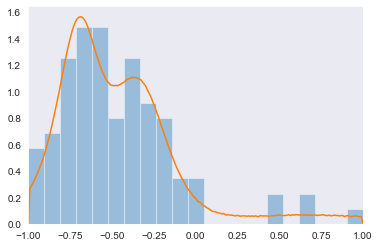

8  Daughter2 Total Momentum (GeV/c)


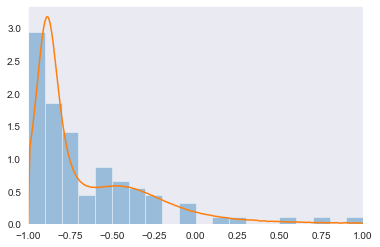

9  Daughter2 Transverse Momentum (GeV/c)


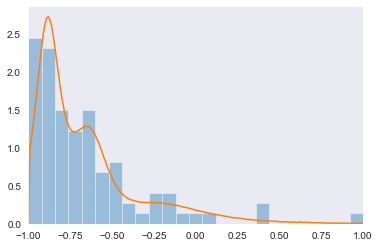

10  Daughter2 Fraction of Transverse Momentum


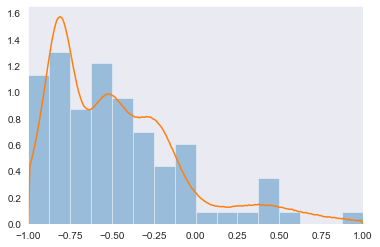

11  Decay Z (cm)


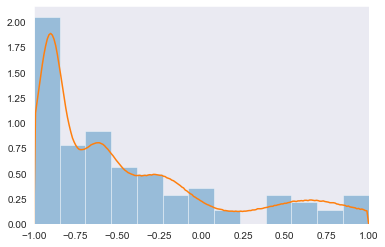

12  Decay X (cm)


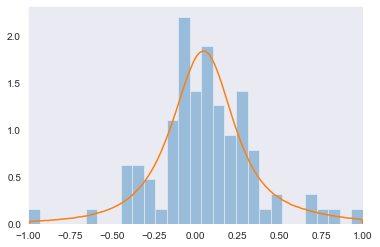

13  Decay Y (cm)


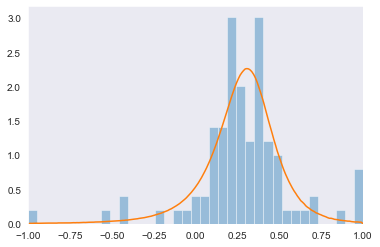

In [28]:
for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_signal.distfit_array[feat].normalise()
    # print(mf_signal.distfit_array[feat].norm_const)
    mf_signal.drawDistComparison(k)
    
    plt.show()

for k, feat in enumerate(feature_names):
    print(k, feat)
    # mf_signal.distfit_array[feat].plotIntegratedComparison()
    mf_background.drawDistComparison(k)
    plt.show()

In [29]:
feature_size = len(mf_signal.features)

# validation data includes the probability dev data

val_signal_size = len(mf_signal.dev_data[feature_names[0]]) 
val_background_size = len(mf_background.dev_data[feature_names[0]])

validation_size = np.min((val_signal_size, val_background_size))
print(validation_size)

signal_select = np.random.choice(range(val_signal_size), validation_size, replace=False)
background_select = np.random.choice(range(val_background_size), validation_size, replace=False)

signal_data = []
background_data = []
validation_data = []

for i in signal_select:
    temp = np.empty(feature_size+1)

    for k, feat in enumerate(mf_signal.dev_data):
        temp[k] = mf_signal.dev_data[feat].iat[i]
    temp[-1]=1
    signal_data.append(temp)
    validation_data.append(temp)

for i in background_select:
    temp = np.empty(feature_size+1)

    for k, feat in enumerate(mf_background.dev_data):
        temp[k] = mf_background.dev_data[feat].iat[i]
    temp[-1]=0
    background_data.append(temp)
    validation_data.append(temp)

# properties data
validation_data = np.random.permutation(validation_data)


552


In [ ]:
type(mf_signal.dev_data[feature_names[1]])

pandas.core.series.Series

In [ ]:
probabilities = []

c_data = background_data

feature_size = len(c_data[0])-1 # the last one is a tag identifying the particle
val_size = len(c_data)

for k in range(feature_size):
    value_arr = np.empty(val_size)
    for i in range(val_size):
        value_arr[i] = c_data[i][k]
    feat = feature_names[k]
    fi = mf_signal.distfit_array[feat].probability_array(value_arr)
    gi = mf_background.distfit_array[feat].probability_array(value_arr)

    temp = fi/(fi+gi)

    del_temp = []

    for i, prob in enumerate(temp):
        if np.isnan(prob):
            del_temp.append(i)
    
    temp = np.delete(temp, del_temp)
    
    probabilities.append(temp)
    # Type 0: background
    # Type 1: signal
    
    # sns.barplot(x=[i for i in range(len(mf_signal.val_data))], y=probabilities)
sns.boxplot(data=probabilities)

In [ ]:
print(len(probabilities[1]))

10


In [ ]:
k = 1
id = 1
val = c_data[id][k]

fi = mf_signal.distfit_array[feature_names[k]].probability(val)
gi = mf_background.distfit_array[feature_names[k]].probability(val)

print(fi, gi)

1.5914440155029301 1.1980533599853513


In [ ]:
def probabilities_barplot(values):
    probabilities = np.empty(len(values))
    for k in range(len(values)):
        value = values[k]
        feat = mf_signal.features[k]
        fi = mf_signal.distfit_array[feat].probability(value)
        gi = mf_background.distfit_array[feat].probability(value)

        probabilities[k] = fi/(fi+gi)
    sns.barplot(x=[i for i in range(len(mf_signal.val_data))], y=probabilities)

In [30]:
def probabilities_boxplot(validation_data):
    feature_size = len(validation_data[0])-1 # the last one is a tag identifying the particle
    val_size = len(validation_data)
    probability_data = []
    # print("feature size: ", feature_size, "; val_size: ", val_size)
    for k in range(feature_size):
        value_arr = np.empty(val_size)
        for i in range(val_size):
            value_arr[i] = validation_data[i][k]
        feat = feature_names[k]
        fi = mf_signal.distfit_array[feat].probability_array(value_arr)
        gi = mf_background.distfit_array[feat].probability_array(value_arr)
        
        temp = np.array(fi/(fi+gi))

        probability_data.append(temp)
    # print(probability_data)
    # print(len(probability_data), len(probability_data[0]))
    # sns.boxplot(data=probability_data)
    return probability_data

In [ ]:
probabilities_boxplot(background_data)

Signal


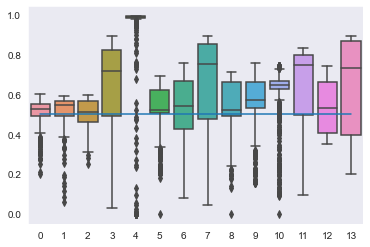

Background


D:\Programs\Anaconda\envs\machine_learn_env\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


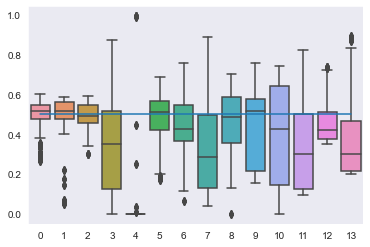

In [31]:
print("Signal")
prob_sig = probabilities_boxplot(signal_data)
plt.plot([0, 13],[0.5,0.5])
# plt.show()
sns.boxplot(data=prob_sig)
plt.show()

print("Background")
prob_bac = probabilities_boxplot(background_data)
sns.boxplot(data=prob_bac)
plt.plot([0, 13],[0.5,0.5])
plt.show()

In [ ]:
feature_size = len(validation_data[0])-1 # the last one is a tag identifying the particle
val_size = len(validation_data)
probability_data = []
print("feature size: ", feature_size, "; val_size: ", val_size)

for k in range(feature_size):
    value_arr = np.empty(val_size)
    for i in range(val_size):
        value_arr[i] = validation_data[i][k]
    
    fi = mf_signal.distfit_array[feat].probability_array(value_arr)
    gi = mf_background.distfit_array[feat].probability_array(value_arr)
    probability_data.append(np.array(fi/(fi+gi)))

print(probability_data)
print(len(probability_data), len(probability_data[0]))
sns.boxplot(data=probability_data)
plt.show()

In [ ]:
len(validation_data)

222

In [ ]:
sns.boxplot(data=probability_data)

In [ ]:
for i, name in enumerate(feature_names):
    print(i, name)

0 Mother Total Momentum (GeV/c)
1  Mother Transverse Momentum (GeV/c)
2  Mother Fraction of Transverse Momentum
3  Opening Angle (rad)
4  Impact Parameter (cm)
5  Daughter1 Total Momentum (GeV/c)
6  Daughter1 Transverse Momentum (GeV/c)
7  Daughter1 Fraction of Transverse Momentum
8  Daughter2 Total Momentum (GeV/c)
9  Daughter2 Transverse Momentum (GeV/c)
10  Daughter2 Fraction of Transverse Momentum
11  Decay Z (cm)
12  Decay X (cm)
13  Decay Y (cm)


## Categorising from probabilities

Classifier model

In [32]:
def getClassifier(inputs, outputs, model, compileArgs):
    classModel = Sequential()

    layerSizes = []
    if model == "model0":
        width = 50
        depth = 5
        step = 5
        for i in range(depth):
            if i==0:
                layerSizes.append(width)
            else:
                layerSizes.append(layerSizes[-1]-step)
    
    for i, width in enumerate(layerSizes):
        if i==0:
            classModel.add(Dense(width, input_shape=(inputs, ), kernel_initializer='normal', activation='relu'))
        else:
            classModel.add(Dropout(0.05)) # play around with this
            classModel.add(Dense(width, kernel_initializer='normal', activation='relu'))

    classModel.add(Dense(outputs, kernel_initializer='normal', activation='sigmoid'))
    
    classModel.compile(**compileArgs)

    return classModel
    


Data preparation

In [33]:
feature_names = mf_signal.features
feature_size = len(feature_names)

signal_data_size = len(mf_signal.dev_data[feature_names[0]])
background_data_size =  len(mf_background.dev_data[feature_names[0]])
data_size = min(signal_data_size, background_data_size)

signal_select = np.random.choice(range(signal_data_size), 
                                 data_size, replace=False)
background_select = np.random.choice(range(background_data_size), 
                                     data_size, replace=False)

# with this signal_select and background_select one can choose train and validation data

signal_traindata = {}
for feat in feature_names:
    signal_traindata[feat] = np.array([mf_signal.dev_data[feat].iat[i] for i in signal_select])

background_traindata = {}
for feat in feature_names:
    background_traindata[feat] = np.array([mf_background.dev_data[feat].iat[i] for i in background_select])

prob0 = {}
prob1 = {}

for k, feat in enumerate(feature_names):
    fi0 = mf_signal.distfit_array[feat].probability_array(background_traindata[feat])
    gi0 = mf_background.distfit_array[feat].probability_array(background_traindata[feat])

    prob0[feat] = fi0/(fi0+gi0)

    fi1 = mf_signal.distfit_array[feat].probability_array(signal_traindata[feat])
    gi1 = mf_background.distfit_array[feat].probability_array(signal_traindata[feat])

    prob1[feat] = fi1/(fi1+gi1)

data_shuffle = np.random.permutation(np.concatenate( (np.zeros(data_size), 
                                                      np.ones(data_size)) ))
probability_data = [] # x_train
signal_id = [] # y_train

for i in range(data_size):
    for j in [0, 1]:
        if data_shuffle[2*i+j] == 0: # if background
            temp = []
            for feat in feature_names:
                temp.append(prob0[feat][i])

            if np.any(np.isnan(temp)):
                continue
            
            probability_data.append(np.array(temp))
            signal_id.append(np.array((0,)))
        elif data_shuffle[2*i+j] == 1: # if signal
            temp = []
            for feat in feature_names:
                temp.append(prob1[feat][i])
            
            if np.any(np.isnan(temp)):
                continue
            
            probability_data.append(np.array(temp))
            signal_id.append(np.array((1,)))

assert not np.any(np.isnan(probability_data))
data_size = len(probability_data)
print(data_size)

D:\Programs\Anaconda\envs\machine_learn_env\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide
D:\Programs\Anaconda\envs\machine_learn_env\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


1088


Preparing train and validation samples 

In [35]:
np.array([1,2,0])/np.array([2,0,0])

D:\Programs\Anaconda\envs\machine_learn_env\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
D:\Programs\Anaconda\envs\machine_learn_env\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.5, inf, nan])

In [36]:
dev_shuffle, val_shuffle = train_test_split(range(data_size), test_size=0.25, random_state=80085)

x_train = np.array([probability_data[i] for i in dev_shuffle])
y_train = np.array([signal_id[i] for i in dev_shuffle])

x_val = np.array([probability_data[i] for i in val_shuffle])
y_val = np.array([signal_id[i] for i in val_shuffle])


In [57]:
np.intersect1d(dev_shuffle, val_shuffle)

array([], dtype=int32)

In [37]:
compileArgs = {'loss':'binary_crossentropy', 
          'optimizer':'Adam'}
trainParams = {'epochs' : 300,
            'batch_size' : 3, 
                'verbose' : 2}

In [39]:

os.chdir("Classification Network/" )

if not os.path.isdir("train_weights"):
    os.mkdir("train_weights")

model = None
model = getClassifier(feature_size, len(y_val[0]),"model0", compileArgs)

lossHistory = LossHistory((x_train, y_train))
earlyStop = EarlyStopping(monitor='loss', patience=30, verbose=0, mode='min')
saveBest = ModelCheckpoint("train_weights/best.h5", monitor='loss', verbose=0, 
                            save_best_only=True, save_weights_only=True, mode='min', save_freq='epoch')
histories = []
results = []


#saveBest = ModelCheckpoint("train_weights/best.h5", monitor='val_loss', verbose=0, 
#                            save_best_only=True, save_weights_only=True, mode='auto', period=1)
   

In [38]:
C.model.metrics_names

['loss']

<bound method Sequential.predict_classes of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f7df80395c0>>

In [36]:
print(len(x_train))
print(len(y_train))

819
819


In [40]:

C = model.fit(x_train, y_train, validation_data=(x_val, y_val), 
              callbacks=[earlyStop, saveBest, lossHistory], **trainParams)
histories.append(lossHistory.losses)
# model.load_weights("train_weights/best.h5")


Train on 816 samples, validate on 272 samples
Epoch 1/300
816/816 - 1s - loss: 0.4329 - val_loss: 0.1260
Epoch 2/300
816/816 - 1s - loss: 0.1700 - val_loss: 0.1005
Epoch 3/300
816/816 - 1s - loss: 0.1323 - val_loss: 0.0707
Epoch 4/300
816/816 - 1s - loss: 0.1179 - val_loss: 0.1042
Epoch 5/300
816/816 - 1s - loss: 0.1198 - val_loss: 0.0717
Epoch 6/300
816/816 - 1s - loss: 0.0808 - val_loss: 0.0672
Epoch 7/300
816/816 - 1s - loss: 0.0770 - val_loss: 0.0457
Epoch 8/300
816/816 - 1s - loss: 0.0621 - val_loss: 0.0237
Epoch 9/300
816/816 - 1s - loss: 0.0505 - val_loss: 0.0263
Epoch 10/300
816/816 - 1s - loss: 0.0637 - val_loss: 0.0531
Epoch 11/300
816/816 - 1s - loss: 0.0479 - val_loss: 0.0391
Epoch 12/300
816/816 - 1s - loss: 0.0405 - val_loss: 0.0470
Epoch 13/300
816/816 - 1s - loss: 0.0372 - val_loss: 0.0169
Epoch 14/300
816/816 - 1s - loss: 0.0265 - val_loss: 0.0188
Epoch 15/300
816/816 - 1s - loss: 0.0233 - val_loss: 0.0212
Epoch 16/300
816/816 - 1s - loss: 0.0272 - val_loss: 0.0300
Epo

816/816 - 1s - loss: 0.0125 - val_loss: 0.0055
Epoch 136/300
816/816 - 1s - loss: 0.0025 - val_loss: 0.0020
Epoch 137/300
816/816 - 1s - loss: 0.0097 - val_loss: 0.0331
Epoch 138/300
816/816 - 1s - loss: 0.0023 - val_loss: 8.5300e-04
Epoch 139/300
816/816 - 1s - loss: 8.5652e-04 - val_loss: 0.0012
Epoch 140/300
816/816 - 1s - loss: 4.1082e-04 - val_loss: 5.5570e-04
Epoch 141/300
816/816 - 1s - loss: 0.0085 - val_loss: 0.0049
Epoch 142/300
816/816 - 1s - loss: 0.0028 - val_loss: 0.0013
Epoch 143/300
816/816 - 1s - loss: 0.0110 - val_loss: 0.0567
Epoch 144/300
816/816 - 1s - loss: 0.0153 - val_loss: 0.0071
Epoch 145/300
816/816 - 1s - loss: 0.0039 - val_loss: 0.0011
Epoch 146/300
816/816 - 1s - loss: 4.1122e-04 - val_loss: 8.3830e-05
Epoch 147/300
816/816 - 1s - loss: 1.6896e-04 - val_loss: 2.1947e-04
Epoch 148/300
816/816 - 1s - loss: 0.0061 - val_loss: 0.0561
Epoch 149/300
816/816 - 1s - loss: 0.0182 - val_loss: 0.0047
Epoch 150/300
816/816 - 1s - loss: 0.0022 - val_loss: 7.3161e-04
Ep

Epoch 262/300
816/816 - 1s - loss: 7.9192e-05 - val_loss: 9.0407e-05
Epoch 263/300
816/816 - 1s - loss: 3.0398e-05 - val_loss: 6.3289e-05
Epoch 264/300
816/816 - 1s - loss: 0.0467 - val_loss: 0.0363
Epoch 265/300
816/816 - 1s - loss: 0.0053 - val_loss: 0.0013
Epoch 266/300
816/816 - 1s - loss: 5.8629e-04 - val_loss: 3.3316e-04
Epoch 267/300
816/816 - 1s - loss: 7.2554e-05 - val_loss: 1.7876e-04
Epoch 268/300
816/816 - 1s - loss: 6.1291e-05 - val_loss: 7.1506e-05
Epoch 269/300
816/816 - 1s - loss: 8.3153e-05 - val_loss: 4.0639e-05
Epoch 270/300
816/816 - 1s - loss: 5.3022e-04 - val_loss: 3.9174e-05
Epoch 271/300
816/816 - 1s - loss: 4.1221e-05 - val_loss: 1.8838e-05
Epoch 272/300
816/816 - 1s - loss: 1.8287e-05 - val_loss: 1.0839e-05
Epoch 273/300
816/816 - 1s - loss: 6.1762e-06 - val_loss: 9.3786e-06
Epoch 274/300
816/816 - 1s - loss: 0.0234 - val_loss: 0.1659
Epoch 275/300
816/816 - 1s - loss: 0.0344 - val_loss: 0.0033
Epoch 276/300
816/816 - 1s - loss: 0.0021 - val_loss: 0.0022
Epoch

In [41]:
model0 = clone_model(model)

In [42]:

results.append({})
model.load_weights("train_weights/best.h5")
results[-1]['loss'] = model.evaluate(x_train, y_train, verbose=0)
# , validation_data = (x_val, y_val)

print("Score is: ", results[-1])




Score is:  {'loss': 1.452730834779202e-07}


In [46]:
# model.save("classification_best_weights/model1.h5")

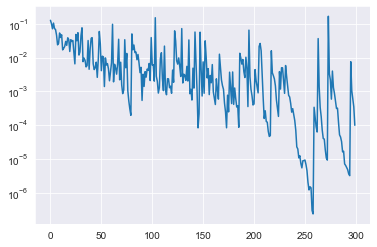

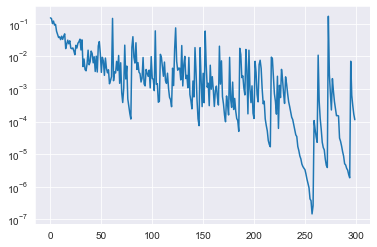

In [43]:

# ax = sns.lineplot(x=[range(100)[:],range(100)[:]],y=lossHistory.losses)
# plt.plot(lossHistory.losses['loss'])
# ay = 
# plt.show()
plt.plot(lossHistory.losses['val_loss'])
plt.yscale("log")
plt.grid(True)
plt.show()

plt.plot(lossHistory.losses['loss'])
plt.yscale("log")
plt.grid(True)
plt.show()

# Model characteristics

In [47]:
model = load_model("classification_best_weights/model1-{}.h5".format())


Score is:  {'loss': 1.452730834779202e-07}


In [49]:
pred_train = model.predict(x_train, verbose=0)
pred_val = model.predict(x_val, verbose=0)

dev_auc = roc_auc_score(y_train[:,0], pred_train[:,0])
val_auc = roc_auc_score(y_val[:,0], pred_val[:,0])

print("dev_auc: ", dev_auc)
print("val_auc: ", val_auc)

dev_auc:  1.0
val_auc:  1.0


In [61]:
print(np.sum(y_val - pred_val))
print(len(y_val))

6.79719035756666e-05
272


In [59]:
fpr, tpr, threshold = roc_curve(y_val, pred_val)

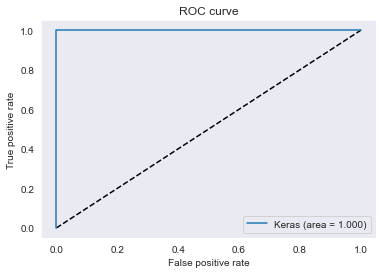

In [62]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(val_auc))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()